In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from tqdm import tqdm
import os
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
import time
%matplotlib inline
from sklearn.neighbors import KDTree
from tqdm import *


import os
USE_GPU = True
os.environ['CUDA_VISIBLE_DEVICES'] = '1' if USE_GPU else ''
EPS = 1e-15

In [2]:
# for phase 1 set num_classes=3
# for phase 2 set num_classes=4
num_classes = 4

energy_cut = 0.01
zero_class_exists = False

num_nn_output = num_classes - (not zero_class_exists)

In [3]:
train_file = 'train_3-4.csv'
test_file = 'test_3-4.csv'
submission_file = 'submission_simplified_3-4_csv.csv'

In [4]:
%load_ext autoreload
%autoreload 2

# Prepare data

In [5]:
import sys

from tools.base import plot_3d, hdf5_to_numpy, plot_3d_with_edges, csv_to_numpy, X_MAX, Y_MAX, Z_MAX
from tools.tools import stretch_array

In [6]:
import os
import psutil

process = psutil.Process(os.getpid())

In [7]:
process.memory_info().rss / 2**30

0.12508773803710938

In [8]:
%%time
X, Y, M, _ = csv_to_numpy(file=train_file, num_classes=num_classes, 
                               zero_class_exists=zero_class_exists, energy_cut=energy_cut)

100%|██████████| 9999/9999 [00:53<00:00, 188.40it/s]

CPU times: user 1min 13s, sys: 18.4 s, total: 1min 31s
Wall time: 1min 35s


In [10]:
def get_pdf(data, bins=75):
    probs, bins = np.histogram(data, bins=bins, density=True)
    indexes = np.digitize(data, bins=bins, right=True)
    return probs[indexes - 1]

def extend_features(cur_data, k=5):
    if len(cur_data) > k:
        tree = KDTree(cur_data)
        neigh = tree.query(cur_data, k=k)[1]
        tmp_data = cur_data[neigh].reshape((len(cur_data), k * 4))
        x = tmp_data[:, 1::4]
        y = tmp_data[:, 2::4]
        z = tmp_data[:, 3::4]
        en = tmp_data[:, 0::4]
        min_x = cur_data[x[::, 0].argmin()]
        min_y = cur_data[y[::, 0].argmin()]
        min_z = cur_data[z[::, 0].argmin()]
        cur_data_coords = cur_data[::, 1:]

        min_x_coords = min_x[1:]
        min_y_coords = min_y[1:]
        min_z_coords = min_z[1:]


        min_x_energy = min_x[0]
        min_y_energy = min_y[0]
        min_z_energy = min_z[0]

        cur_data_energy = cur_data[::, 0]

        dif_x_eng = cur_data_energy - min_x_energy
        dif_y_eng = cur_data_energy - min_y_energy
        dif_z_eng = cur_data_energy - min_z_energy



        x_dist = np.sum((cur_data_coords - min_x_coords) ** 2, axis=-1) ** 0.5
        y_dist = np.sum((cur_data_coords - min_y_coords) ** 2, axis=-1) ** 0.5
        z_dist = np.sum((cur_data_coords - min_z_coords) ** 2, axis=-1) ** 0.5
        
        x_probs = get_pdf(cur_data[::, 1])[::, np.newaxis]
        y_probs = get_pdf(cur_data[::, 2])[::, np.newaxis]
        z_probs = get_pdf(cur_data[::, 3])[::, np.newaxis]
        en_probs = get_pdf(cur_data[::, 0])[::, np.newaxis]

        features = (tmp_data,
                  x.mean(axis=-1)[::, np.newaxis],
                  y.mean(axis=-1)[::, np.newaxis],
                  z.mean(axis=-1)[::, np.newaxis],
                  x.ptp(axis=-1)[::, np.newaxis],
                  y.ptp(axis=-1)[::, np.newaxis],
                  z.ptp(axis=-1)[::, np.newaxis],
                  x.var(axis=-1)[::, np.newaxis],
                  y.var(axis=-1)[::, np.newaxis],
                  z.var(axis=-1)[::, np.newaxis],
                  en.mean(axis=-1)[::, np.newaxis],
                  en.std(axis=-1)[::, np.newaxis],
                  en.var(axis=-1)[::, np.newaxis],
                  en.ptp(axis=-1)[::, np.newaxis],
                    x_dist[::, np.newaxis],
                    y_dist[::, np.newaxis],
                    z_dist[::, np.newaxis],
                    dif_x_eng[::, np.newaxis],
                    dif_y_eng[::, np.newaxis],
                    dif_z_eng[::, np.newaxis],
                    x_probs,
                    y_probs,
                    z_probs,
                    en_probs
                )

        return np.hstack(features)

In [11]:
for i in trange(len(X)):
    X[i] = extend_features(X[i])

100%|██████████| 9999/9999 [02:56<00:00, 56.79it/s]


In [12]:
X[0].shape

(1375, 43)

In [103]:
import pickle

with open('readen_train_ext_csv.pickle', 'wb') as f:
    pickle.dump([X, Y, M, _], f)

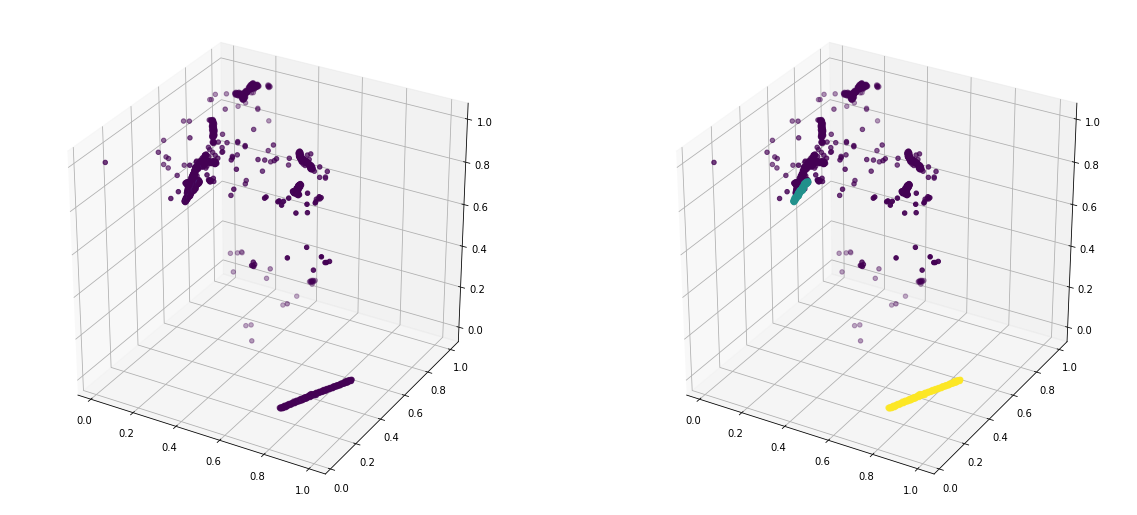

In [17]:
k = -1
plot_3d(X[k], Y[k])

## Creation of graph dataset


![title](img/knn_graph.png)

To compute graph on which we are going to do inference we will use K-nearest neighbours graph. This algorithm draws edges from node(which is, in our case, a hit in the detector) to K closest points.

Tunable parameter:

__n_neighbors__ -- number of neighbours for k-nearest neighbours graph algo(http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html).

### Ideas

  * try to play with default params;
  * explore different ideas for graph computation: heuristics, radius neighbors graph, etc.;
  * different metrics: manhattan, l1, cosine, metric learning(__hot!__), etc.;

In [16]:
n_neighbors = 20

in_degree_max, out_degree_max = 0, 0

In [17]:
from tools.simplified_clustering import generate_graph_dataset

In [18]:
X_clusters_graph = []

In [19]:
in_degree_max

0

In [112]:
def trans_data(k, in_degree_max, out_degree_max):
    try:
        if len(X[k]) < n_neighbors:
            return None
        # construction of graph based on aggregated statistics
        X_cluster_graph, in_degree_max_local, out_degree_max_local = generate_graph_dataset(X=X[k], Y=Y[k], M=M[k],
                                                                                            n_neighbors=n_neighbors)
        in_degree_max = max(in_degree_max_local, in_degree_max)
        out_degree_max = max(out_degree_max_local, out_degree_max)
        
        X_cluster_graph['X_cluster_messages_out'] = stretch_array(X_cluster_graph['X_cluster_messages_out'], 
                                                              n=out_degree_max, 
                                                              fill_value=len(X_cluster_graph['X_cluster_edges']))
    
        X_cluster_graph['X_cluster_messages_in'] = stretch_array(X_cluster_graph['X_cluster_messages_in'], 
                                                              n=in_degree_max, 
                                                              fill_value=len(X_cluster_graph['X_cluster_edges']))

        return X_cluster_graph
    except:
        return None

In [106]:
tmp = trans_data(2, in_degree_max, out_degree_max)

In [111]:
tmp['X_cluster_messages_in'].shape

(1137, 60)

In [104]:
in_degree_max, out_degree_max

(60, 20)

In [21]:
for k in tqdm(range(len(X))):
    try:
        if len(X[k]) < n_neighbors:
            continue
        # construction of graph based on aggregated statistics
        X_cluster_graph, in_degree_max_local, out_degree_max_local = generate_graph_dataset(X=X[k], Y=Y[k], M=M[k],
                                                                                            n_neighbors=n_neighbors)
        in_degree_max = max(in_degree_max_local, in_degree_max)
        out_degree_max = max(out_degree_max_local, out_degree_max)

        #X_clusters_graph.append(X_cluster_graph)
    except:
        print(k)

 29%|██▉       | 2902/9999 [08:44<21:23,  5.53it/s]

2902


 41%|████▏     | 4146/9999 [12:33<17:43,  5.50it/s]

4144


 63%|██████▎   | 6328/9999 [18:58<11:00,  5.56it/s]

6326


 87%|████████▋ | 8671/9999 [26:05<03:59,  5.54it/s]

8669


100%|██████████| 9999/9999 [30:11<00:00,  5.52it/s]


In [32]:
in_degree_max, out_degree_max

(60, 20)

In [12]:
k

9998

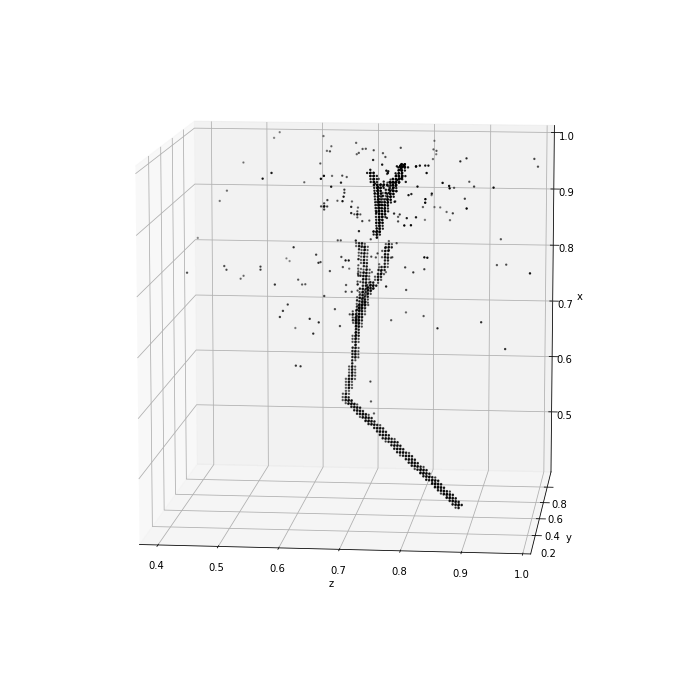

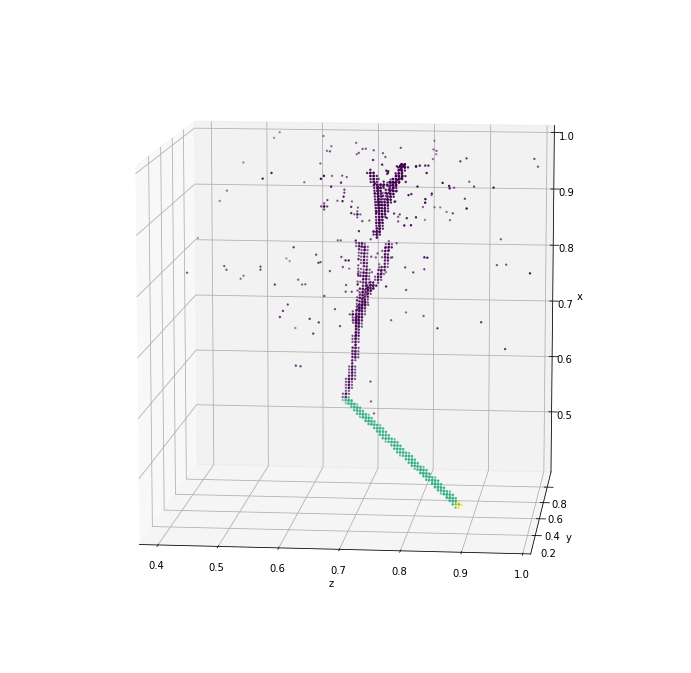

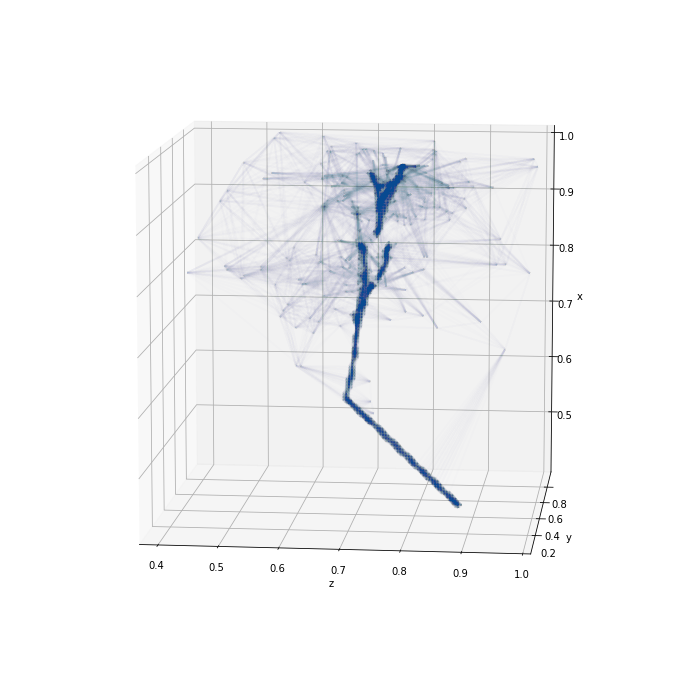

In [13]:
k = 0
plot_3d_with_edges(X[k], Y[k], X_clusters_graph[k]['X_cluster_in_out'])

### What is __in_degree_max__ and __out_degree_max__?

Well, when you are working with tensorflow you have to specify shape of your data(at least number of columns).

```
shape = (number_of_nodes, out_degree/in_degree)
```

__max_out_degree__ is fixed and equal __n_neighbors__ in our setting, but __in_degree_max__ could be different across different events. 

To anticipate it we are padding all events with edges to non-existing node. Latter this should be taken into account in the MPNN-algorithm.

In [ ]:
in_degree_max, out_degree_max

In [ ]:
# padding
for X_cluster_graph in X_clusters_graph:
    X_cluster_graph['X_cluster_messages_out'] = stretch_array(X_cluster_graph['X_cluster_messages_out'], 
                                                              n=out_degree_max, 
                                                              fill_value=len(X_cluster_graph['X_cluster_edges']))
    
    X_cluster_graph['X_cluster_messages_in'] = stretch_array(X_cluster_graph['X_cluster_messages_in'], 
                                                              n=in_degree_max, 
                                                              fill_value=len(X_cluster_graph['X_cluster_edges']))

# Deep learning model (MPNN)




In [113]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, GRUCell, GRU, BatchNormalization
from keras.optimizers import RMSprop
from keras import backend as K
import keras
import tensorflow as tf
from keras.layers import Dropout
from keras.models import Sequential
from keras.activations import relu

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

### Placeholders

In [114]:
X_cluster_graph['X_cluster_nodes'].shape, X_cluster_graph['X_cluster_edges'].shape

((673, 1), (13460, 44))

__X_nodes__ -- features per hit(i.e. energy).

__X_edges__ -- features for each edge that connects two hits(i.e. relative difference of coordinates).

__X_labels__ -- labels ;)

In [115]:
ndim_features_nodes = 43
ndim_features_edges = 5
ndim_message = 6

X_nodes = K.placeholder(shape=(None, ndim_features_nodes)) # features of nodes
X_edges = K.placeholder(shape=(None, ndim_features_edges)) # features of edges
X_labels = K.placeholder(shape=(None, num_nn_output)) # labels

__X_nodes_in_out__ -- edge list.

__X_messages_in__ -- in-adjacency lists.

__X_messages_out__ -- out-adjacency lists.

All these graph representations are equivalent. 

In [116]:
X_nodes_in_out = K.placeholder(shape=(None, 2), dtype=np.int32) # edges
X_messages_in = K.placeholder(shape=(None, in_degree_max), dtype=np.int32) # shape = (none, size of neighbourhood)
X_messages_out = K.placeholder(shape=(None, out_degree_max), dtype=np.int32) # shape = (none, size of neighbourhood)

# fake messages to(or from) non-existing node
fake_message_const = K.constant(value=[ndim_message * [-np.inf]]) 

In [117]:
placeholders = {
    'X_nodes': X_nodes,
    'X_edges': X_edges,
    'X_labels': X_labels,
    'X_nodes_in_out': X_nodes_in_out,
    'X_messages_in': X_messages_in,
    'X_messages_out': X_messages_out
}

### NNs

In [118]:
steps = 3

message_passers = {
    0: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu),
                        #BatchNormalization(axis=1),
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ]
                 ),
    1: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu),
                        #BatchNormalization(axis=1),
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ]
                 ),    
    2: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu),
                        #BatchNormalization(axis=1),
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ]
                 )
}

In [119]:
#state_updater = tf.contrib.rnn.GRUCell(num_units=ndim_features_nodes, )
state_updater = Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_message + ndim_features_nodes,), activation=relu),
                    BatchNormalization(axis=1),
                      Dense(ndim_features_nodes),
                                  ]
                          )

In [120]:
readout = Dense(num_nn_output, input_shape=(ndim_features_nodes,), activation=keras.activations.softmax)

### MPNN construction

A brief explanation of MPNN algorithm in a diagram for a following toy graph:

![](img/example_graph.png)

Algorithm:

![](img/mpnn.png)


And corresponding code with comments:

In [121]:
def build_network(X_nodes, X_edges, X_nodes_in_out, 
                  X_messages_in, X_messages_out, message_passers, 
                  state_updater, readout, ndim_features_nodes, fake_message_const, steps):
    # nodes 'talks' to each other several times which is defined by __step__ parameter
    for step in range(steps):
        # messages from node to node
        messages = message_passers[step](
            K.concatenate(
                [
                    K.reshape(K.gather(reference=X_nodes, indices=X_nodes_in_out), 
                              shape=(-1, 2 * ndim_features_nodes)), 
                    X_edges
                ], axis=1
            )
        )
        # correct dealing with non-existing edge
        messages = K.concatenate([messages, fake_message_const], axis=0)
        messages = tf.where(tf.is_inf(messages), tf.zeros_like(messages), messages)

        # aggregating messages that came into the node
        messages_aggregated_in = K.max(K.gather(reference=messages, indices=X_messages_in), axis=1)
        # ... and those exiting node
        messages_aggregated_out = K.max(K.gather(reference=messages, indices=X_messages_out), axis=1)

        # update nodes states based on messages and previous state
        X_nodes = state_updater(K.concatenate([messages_aggregated_in, messages_aggregated_out, X_nodes], axis=1))

    return readout(X_nodes)

In [122]:
from tools.mpnn import build_network, run_train, run_test

In [123]:
X_predictions = build_network(X_nodes=X_nodes, 
                              X_edges=X_edges, 
                              X_nodes_in_out=X_nodes_in_out, 
                              X_messages_in=X_messages_in, 
                              X_messages_out=X_messages_out, 
                              message_passers=message_passers, 
                              state_updater=state_updater, 
                              readout=readout, 
                              steps=steps, 
                              ndim_features_nodes=ndim_features_nodes,
                              fake_message_const=fake_message_const)

In [124]:
loss_tf = tf.reduce_mean(keras.losses.categorical_crossentropy(X_labels, X_predictions))
accuracy_tf = tf.reduce_mean(keras.metrics.categorical_accuracy(X_labels, X_predictions))

In [125]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_tf, var_list=tf.trainable_variables())

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [126]:
sess = tf.Session()
init = tf.global_variables_initializer()
init.run(session=sess)

## Split dataset

In [127]:
TRAIN_SIZE = int(len(X_clusters_graph) * 0.99)
print(TRAIN_SIZE)
shuffle(X_clusters_graph)

X_clusters_graph_train = X_clusters_graph[:TRAIN_SIZE]
X_clusters_graph_eval = X_clusters_graph[TRAIN_SIZE:]

0


### Train

In [128]:
placeholders

{'X_nodes': <tf.Tensor 'Placeholder_24:0' shape=(?, 43) dtype=float32>,
 'X_edges': <tf.Tensor 'Placeholder_25:0' shape=(?, 5) dtype=float32>,
 'X_labels': <tf.Tensor 'Placeholder_26:0' shape=(?, 3) dtype=float32>,
 'X_nodes_in_out': <tf.Tensor 'Placeholder_27:0' shape=(?, 2) dtype=int32>,
 'X_messages_in': <tf.Tensor 'Placeholder_28:0' shape=(?, 60) dtype=int32>,
 'X_messages_out': <tf.Tensor 'Placeholder_29:0' shape=(?, 20) dtype=int32>}

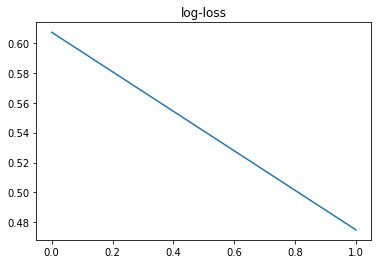

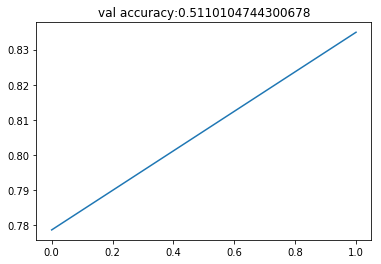




 20%|██        | 2/10 [1:14:19<4:57:17, 2229.64s/it]



  0%|          | 0/9900 [00:00<?, ?it/s]



  0%|          | 1/9900 [00:00<32:28,  5.08it/s]



  0%|          | 2/9900 [00:00<37:35,  4.39it/s]



  0%|          | 3/9900 [00:00<31:49,  5.18it/s]



  0%|          | 4/9900 [00:00<32:16,  5.11it/s]



  0%|          | 5/9900 [00:00<29:12,  5.65it/s]



  0%|          | 6/9900 [00:01<28:42,  5.75it/s]



  0%|          | 7/9900 [00:01<29:01,  5.68it/s]



  0%|          | 9/9900 [00:01<25:09,  6.55it/s]



  0%|          | 10/9900 [00:01<24:52,  6.63it/s]



  0%|          | 11/9900 [00:01<28:13,  5.84it/s]



  0%|          | 12/9900 [00:02<28:49,  5.72it/s]



  0%|          | 14/9900 [00:02<27:08,  6.07it/s]



  0%|          | 15/9900 [00:02<27:10,  6.06it/s]



  0%|          | 16/9900 [00:02<28:54,  5.70it/s]



  0%|          | 17/9900 [00:03<34:09,  4.82it/s]



  0%|          | 18/9900 [00:03<33:29,  4.92it/s]



  0%|          | 19/9900 [00:03<33:14,  4.95it/s]



  0%

In [ ]:
from sklearn import metrics


losses = []
accuracies = []
roc_aucs = []

val_accs = []

for epoch in tqdm(range(10)):
    loss_float = 0
    accuracy_float = 0
    
    losses_epoch = []
    accuracies_epoch = []
    roc_aucs_epoch = []
    for cur_box in trange(9900):
        X_cluster_graph = trans_data(cur_box, in_degree_max, out_degree_max)
        if X_cluster_graph:
            predictions, (loss, accuracy) = run_train(X_cluster_graph=X_cluster_graph,
                                       X_predictions=X_predictions,
                                       optimizer=optimizer, sess=sess, 
                                       ndim_features_nodes=ndim_features_nodes, 
                                       ndim_features_edges=ndim_features_edges, 
                                       placeholders=placeholders,
                                       metrics=[loss_tf, accuracy_tf])
            losses_epoch.append(loss)
            accuracies_epoch.append(accuracy)
        else:
            print('Error train')
        
    
    losses_test = []
    accuracies_test = []
    roc_aucs_test = []
    predictions_total = [] 
    y_total =[]

    for cur_box in trange(9900, 10000):
        X_cluster_graph = trans_data(cur_box, in_degree_max, out_degree_max)
        if X_cluster_graph:
            predictions = run_test(X_cluster_graph=X_cluster_graph, 
                                                      X_predictions=X_predictions,
                                                      sess=sess, 
                                                      ndim_features_nodes=ndim_features_nodes, 
                                                      ndim_features_edges=ndim_features_edges, 
                                                      placeholders=placeholders)
            X_cluster_graph['predictions'] = predictions
            predictions_total.append(predictions)
            y_total.append(X_cluster_graph['Y_cluster_labels'])

        
    predictions_total = np.concatenate(predictions_total)
    y_total = np.concatenate(y_total)
    pred_flatted = []
    for elem in predictions_total:
        for cur_el in elem:
            pred_flatted.append(cur_el.argmax())
            
    accuracy = metrics.accuracy_score(np.argmax(y_total, axis=1), pred_flatted)
    val_accs.append(accuracy)
    
    clear_output()
    
    losses.append(np.mean(losses_epoch))
    plt.title('log-loss')
    plt.plot(losses)
    plt.show()

    accuracies.append(np.mean(accuracies_epoch))
    plt.title('val accuracy:' + str(accuracy))
    plt.plot(accuracies)
    plt.show()

### Eval

In [36]:
losses_test = []
accuracies_test = []
roc_aucs_test = []
predictions_total = [] 
y_total =[]

for cur_box in trange(9900, 10000):
    X_cluster_graph = trans_data(cur_box, in_degree_max, out_degree_max)
        if X_cluster_graph:
    predictions = run_test(X_cluster_graph=X_cluster_graph, 
                                              X_predictions=X_predictions,
                                              sess=sess, 
                                              ndim_features_nodes=ndim_features_nodes, 
                                              ndim_features_edges=ndim_features_edges, 
                                              placeholders=placeholders)
    X_cluster_graph['predictions'] = predictions
    predictions_total.append(predictions)
    y_total.append(X_cluster_graph['Y_cluster_labels'])
    losses_test.append(loss)
    accuracies_test.append(accuracy)

In [37]:
predictions_total = np.concatenate(predictions_total)
y_total = np.concatenate(y_total)

In [51]:
predictions_total = np.concatenate(predictions_total)

ValueError: all the input arrays must have same number of dimensions

In [65]:
pred_flatted = []
for elem in predictions_total:
    for cur_el in elem:
        pred_flatted.append(cur_el.argmax())

In [64]:
predictions_total[0][0]

array([9.9567705e-01, 3.3458258e-07, 4.3225661e-03], dtype=float32)

In [70]:
from collections import Counter
Counter(y_total.argmax(axis=1))

Counter({1: 22183, 0: 105467, 2: 52809})

In [74]:
from sklearn import metrics
accuracy = metrics.accuracy_score(np.argmax(y_total, axis=1), pred_flatted)
#roc_auc = metrics.roc_auc_score(y_total, predictions_total)

In [72]:
accuracy

0.5844319208241208

## Test

In [79]:
test_file

'test_3-4.csv'

In [80]:
X_test, Y_test, M_test, events_test = csv_to_numpy(file=test_file, num_classes=num_classes, test=True,
                                                   zero_class_exists=zero_class_exists, energy_cut=energy_cut)
shift = 0 if zero_class_exists else 1





  0%|          | 0/9999 [00:00<?, ?it/s]



  0%|          | 1/9999 [00:04<13:04:40,  4.71s/it]



  1%|          | 56/9999 [00:04<14:13, 11.65it/s]  



  1%|          | 112/9999 [00:04<07:13, 22.82it/s]



  2%|▏         | 164/9999 [00:05<05:00, 32.74it/s]



  2%|▏         | 222/9999 [00:05<03:45, 43.44it/s]



  3%|▎         | 273/9999 [00:05<03:05, 52.37it/s]



  3%|▎         | 327/9999 [00:05<02:37, 61.54it/s]



  4%|▍         | 375/9999 [00:05<02:19, 69.05it/s]



  4%|▍         | 421/9999 [00:05<02:06, 75.73it/s]



  5%|▍         | 464/9999 [00:05<01:57, 81.02it/s]



  5%|▌         | 502/9999 [00:05<01:51, 85.05it/s]



  5%|▌         | 535/9999 [00:06<01:46, 88.71it/s]



  6%|▌         | 566/9999 [00:06<01:42, 91.81it/s]



  6%|▌         | 595/9999 [00:06<01:39, 94.67it/s]



  6%|▌         | 623/9999 [00:06<01:36, 97.02it/s]



  6%|▋         | 649/9999 [00:06<01:34, 99.45it/s]



  7%|▋         | 674/9999 [00:06<01:31, 101.65it/s]



  7%|▋         | 699/9999 [00:0

 37%|███▋      | 3738/9999 [00:18<00:30, 202.26it/s]



 38%|███▊      | 3758/9999 [00:18<00:30, 202.23it/s]



 38%|███▊      | 3779/9999 [00:18<00:30, 202.26it/s]



 38%|███▊      | 3800/9999 [00:18<00:30, 201.91it/s]



 38%|███▊      | 3828/9999 [00:18<00:30, 202.32it/s]



 39%|███▊      | 3874/9999 [00:19<00:30, 203.65it/s]



 39%|███▉      | 3922/9999 [00:19<00:29, 205.09it/s]



 40%|███▉      | 3972/9999 [00:19<00:29, 206.61it/s]



 40%|████      | 4016/9999 [00:19<00:28, 207.80it/s]



 41%|████      | 4065/9999 [00:19<00:28, 209.23it/s]



 41%|████      | 4112/9999 [00:19<00:27, 210.55it/s]



 42%|████▏     | 4161/9999 [00:19<00:27, 211.97it/s]



 42%|████▏     | 4207/9999 [00:19<00:27, 213.17it/s]



 43%|████▎     | 4253/9999 [00:19<00:26, 214.40it/s]



 43%|████▎     | 4298/9999 [00:19<00:26, 215.16it/s]



 43%|████▎     | 4340/9999 [00:20<00:26, 215.86it/s]



 44%|████▍     | 4379/9999 [00:20<00:26, 216.15it/s]



 44%|████▍     | 4414/9999 [00:20<00:25, 216.38i

 77%|███████▋  | 7724/9999 [00:31<00:09, 244.20it/s]



 78%|███████▊  | 7751/9999 [00:31<00:09, 244.27it/s]



 78%|███████▊  | 7777/9999 [00:31<00:09, 244.31it/s]



 78%|███████▊  | 7803/9999 [00:31<00:08, 244.32it/s]



 78%|███████▊  | 7829/9999 [00:32<00:08, 244.29it/s]



 79%|███████▊  | 7855/9999 [00:32<00:08, 244.31it/s]



 79%|███████▉  | 7880/9999 [00:32<00:08, 244.20it/s]



 79%|███████▉  | 7904/9999 [00:32<00:08, 244.17it/s]



 79%|███████▉  | 7932/9999 [00:32<00:08, 244.29it/s]



 80%|███████▉  | 7959/9999 [00:32<00:08, 244.34it/s]



 80%|███████▉  | 7985/9999 [00:32<00:08, 244.37it/s]



 80%|████████  | 8013/9999 [00:32<00:08, 244.45it/s]



 80%|████████  | 8039/9999 [00:32<00:08, 244.46it/s]



 81%|████████  | 8067/9999 [00:32<00:07, 244.57it/s]



 81%|████████  | 8095/9999 [00:33<00:07, 244.65it/s]



 81%|████████  | 8122/9999 [00:33<00:07, 244.60it/s]



 81%|████████▏ | 8148/9999 [00:33<00:07, 244.60it/s]



 82%|████████▏ | 8174/9999 [00:33<00:07, 244.51i

In [82]:
predictions

(array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32), [])

In [83]:
import tables
preds_array = []

for k, event in tqdm(list(enumerate(events_test))):
        X_cluster_graph, in_degree_max_local, out_degree_max_local = generate_graph_dataset(X=X_test[k], 
                                                                                            Y=Y_test[k], 
                                                                                            M=M_test[k],
                                                                                            n_neighbors=n_neighbors, 
                                                                                            in_degree_max=in_degree_max, 
                                                                                            out_degree_max=out_degree_max)
        
        predictions = run_test(X_cluster_graph=X_cluster_graph, 
                                               X_predictions=X_predictions,
                                               sess=sess, 
                                               ndim_features_nodes=ndim_features_nodes, 
                                               ndim_features_edges=ndim_features_edges, 
                                               placeholders=placeholders)
        preds_array.append(pd.DataFrame.from_dict(
            {
                'x': (X_test[k][:, 0] * X_MAX).astype(int), 
                'y': (X_test[k][:, 1] * Y_MAX).astype(int), 
                'z': (X_test[k][:, 2] * Z_MAX).astype(int),
                'event': event, 
                'pred': np.argmax(predictions[0], axis=1) + shift,
        }))






  0%|          | 0/9999 [00:00<?, ?it/s]



  0%|          | 2/9999 [00:00<40:07,  4.15it/s]



  0%|          | 3/9999 [00:01<56:58,  2.92it/s]



  0%|          | 5/9999 [00:01<40:05,  4.15it/s]



  0%|          | 6/9999 [00:01<43:36,  3.82it/s]



  0%|          | 7/9999 [00:02<48:16,  3.45it/s]



  0%|          | 8/9999 [00:02<44:35,  3.73it/s]



  0%|          | 10/9999 [00:02<40:43,  4.09it/s]



  0%|          | 11/9999 [00:02<41:12,  4.04it/s]



  0%|          | 13/9999 [00:02<36:24,  4.57it/s]



  0%|          | 14/9999 [00:03<36:09,  4.60it/s]



  0%|          | 15/9999 [00:03<36:00,  4.62it/s]



  0%|          | 16/9999 [00:03<35:19,  4.71it/s]



  0%|          | 17/9999 [00:03<35:02,  4.75it/s]



  0%|          | 18/9999 [00:03<36:14,  4.59it/s]



  0%|          | 19/9999 [00:04<36:31,  4.55it/s]



  0%|          | 20/9999 [00:04<35:33,  4.68it/s]



  0%|          | 22/9999 [00:04<34:22,  4.84it/s]



  0%|          | 25/9999 [00:04<31:57,  5.20it/s]



  0%

  2%|▏         | 173/9999 [00:37<35:15,  4.65it/s]



  2%|▏         | 175/9999 [00:37<35:01,  4.68it/s]



  2%|▏         | 176/9999 [00:37<34:56,  4.69it/s]



  2%|▏         | 177/9999 [00:37<34:49,  4.70it/s]



  2%|▏         | 178/9999 [00:37<34:47,  4.70it/s]



  2%|▏         | 179/9999 [00:38<34:49,  4.70it/s]



  2%|▏         | 180/9999 [00:38<34:44,  4.71it/s]



  2%|▏         | 181/9999 [00:38<34:46,  4.71it/s]



  2%|▏         | 182/9999 [00:38<34:41,  4.72it/s]



  2%|▏         | 183/9999 [00:38<34:50,  4.70it/s]



  2%|▏         | 185/9999 [00:39<35:04,  4.66it/s]



  2%|▏         | 186/9999 [00:39<34:58,  4.68it/s]



  2%|▏         | 187/9999 [00:39<34:53,  4.69it/s]



  2%|▏         | 189/9999 [00:40<34:41,  4.71it/s]



  2%|▏         | 190/9999 [00:40<34:41,  4.71it/s]



  2%|▏         | 192/9999 [00:40<34:31,  4.73it/s]



  2%|▏         | 194/9999 [00:40<34:17,  4.76it/s]



  2%|▏         | 195/9999 [00:40<34:17,  4.76it/s]



  2%|▏         | 196/9999 [0

  3%|▎         | 327/9999 [01:10<34:31,  4.67it/s]



  3%|▎         | 329/9999 [01:10<34:27,  4.68it/s]



  3%|▎         | 331/9999 [01:10<34:17,  4.70it/s]



  3%|▎         | 333/9999 [01:10<34:08,  4.72it/s]



  3%|▎         | 336/9999 [01:10<33:55,  4.75it/s]



  3%|▎         | 338/9999 [01:10<33:45,  4.77it/s]



  3%|▎         | 340/9999 [01:11<33:38,  4.79it/s]



  3%|▎         | 342/9999 [01:11<33:33,  4.80it/s]



  3%|▎         | 344/9999 [01:11<33:30,  4.80it/s]



  3%|▎         | 346/9999 [01:12<33:29,  4.80it/s]



  3%|▎         | 347/9999 [01:12<33:29,  4.80it/s]



  3%|▎         | 349/9999 [01:13<33:59,  4.73it/s]



  4%|▎         | 350/9999 [01:13<33:59,  4.73it/s]



  4%|▎         | 351/9999 [01:14<33:56,  4.74it/s]



  4%|▎         | 352/9999 [01:14<33:53,  4.74it/s]



  4%|▎         | 353/9999 [01:14<33:51,  4.75it/s]



  4%|▎         | 354/9999 [01:14<33:54,  4.74it/s]



  4%|▎         | 355/9999 [01:14<33:51,  4.75it/s]



  4%|▎         | 356/9999 [0

  5%|▍         | 492/9999 [01:42<33:09,  4.78it/s]



  5%|▍         | 493/9999 [01:43<33:10,  4.78it/s]



  5%|▍         | 494/9999 [01:43<33:15,  4.76it/s]



  5%|▍         | 495/9999 [01:44<33:26,  4.74it/s]



  5%|▍         | 497/9999 [01:45<33:38,  4.71it/s]



  5%|▍         | 498/9999 [01:45<33:37,  4.71it/s]



  5%|▌         | 501/9999 [01:45<33:28,  4.73it/s]



  5%|▌         | 503/9999 [01:46<33:22,  4.74it/s]



  5%|▌         | 505/9999 [01:46<33:17,  4.75it/s]



  5%|▌         | 507/9999 [01:46<33:15,  4.76it/s]



  5%|▌         | 510/9999 [01:46<33:05,  4.78it/s]



  5%|▌         | 512/9999 [01:46<33:00,  4.79it/s]



  5%|▌         | 514/9999 [01:47<33:05,  4.78it/s]



  5%|▌         | 515/9999 [01:47<33:05,  4.78it/s]



  5%|▌         | 517/9999 [01:48<33:01,  4.78it/s]



  5%|▌         | 518/9999 [01:48<33:02,  4.78it/s]



  5%|▌         | 519/9999 [01:48<33:00,  4.79it/s]



  5%|▌         | 520/9999 [01:48<32:59,  4.79it/s]



  5%|▌         | 521/9999 [0

  7%|▋         | 664/9999 [02:17<32:07,  4.84it/s]



  7%|▋         | 665/9999 [02:17<32:06,  4.85it/s]



  7%|▋         | 666/9999 [02:17<32:07,  4.84it/s]



  7%|▋         | 667/9999 [02:18<32:12,  4.83it/s]



  7%|▋         | 668/9999 [02:18<32:17,  4.82it/s]



  7%|▋         | 669/9999 [02:19<32:26,  4.79it/s]



  7%|▋         | 670/9999 [02:19<32:27,  4.79it/s]



  7%|▋         | 672/9999 [02:20<32:25,  4.79it/s]



  7%|▋         | 673/9999 [02:20<32:24,  4.80it/s]



  7%|▋         | 674/9999 [02:20<32:22,  4.80it/s]



  7%|▋         | 675/9999 [02:20<32:22,  4.80it/s]



  7%|▋         | 677/9999 [02:20<32:18,  4.81it/s]



  7%|▋         | 679/9999 [02:20<32:14,  4.82it/s]



  7%|▋         | 681/9999 [02:21<32:14,  4.82it/s]



  7%|▋         | 682/9999 [02:22<32:20,  4.80it/s]



  7%|▋         | 683/9999 [02:22<32:22,  4.80it/s]



  7%|▋         | 684/9999 [02:22<32:20,  4.80it/s]



  7%|▋         | 685/9999 [02:23<32:26,  4.78it/s]



  7%|▋         | 686/9999 [0

  8%|▊         | 832/9999 [02:51<31:29,  4.85it/s]



  8%|▊         | 833/9999 [02:51<31:28,  4.85it/s]



  8%|▊         | 834/9999 [02:51<31:27,  4.86it/s]



  8%|▊         | 836/9999 [02:51<31:24,  4.86it/s]



  8%|▊         | 838/9999 [02:52<31:27,  4.85it/s]



  8%|▊         | 840/9999 [02:52<31:25,  4.86it/s]



  8%|▊         | 841/9999 [02:53<31:28,  4.85it/s]



  8%|▊         | 842/9999 [02:53<31:27,  4.85it/s]



  8%|▊         | 843/9999 [02:53<31:27,  4.85it/s]



  8%|▊         | 844/9999 [02:53<31:27,  4.85it/s]



  8%|▊         | 846/9999 [02:54<31:30,  4.84it/s]



  8%|▊         | 847/9999 [02:55<31:30,  4.84it/s]



  8%|▊         | 848/9999 [02:55<31:31,  4.84it/s]



  8%|▊         | 849/9999 [02:55<31:30,  4.84it/s]



  9%|▊         | 850/9999 [02:55<31:29,  4.84it/s]



  9%|▊         | 851/9999 [02:55<31:28,  4.84it/s]



  9%|▊         | 853/9999 [02:56<31:28,  4.84it/s]



  9%|▊         | 854/9999 [02:56<31:28,  4.84it/s]



  9%|▊         | 856/9999 [0

 10%|▉         | 988/9999 [03:25<31:18,  4.80it/s]



 10%|▉         | 989/9999 [03:26<31:18,  4.80it/s]



 10%|▉         | 990/9999 [03:26<31:17,  4.80it/s]



 10%|▉         | 991/9999 [03:26<31:16,  4.80it/s]



 10%|▉         | 992/9999 [03:26<31:15,  4.80it/s]



 10%|▉         | 993/9999 [03:26<31:14,  4.81it/s]



 10%|▉         | 995/9999 [03:26<31:12,  4.81it/s]



 10%|▉         | 996/9999 [03:27<31:11,  4.81it/s]



 10%|▉         | 997/9999 [03:28<31:18,  4.79it/s]



 10%|▉         | 998/9999 [03:28<31:18,  4.79it/s]



 10%|█         | 1000/9999 [03:28<31:15,  4.80it/s]



 10%|█         | 1001/9999 [03:28<31:15,  4.80it/s]



 10%|█         | 1002/9999 [03:28<31:14,  4.80it/s]



 10%|█         | 1003/9999 [03:29<31:15,  4.80it/s]



 10%|█         | 1004/9999 [03:29<31:13,  4.80it/s]



 10%|█         | 1005/9999 [03:29<31:17,  4.79it/s]



 10%|█         | 1006/9999 [03:29<31:16,  4.79it/s]



 10%|█         | 1008/9999 [03:30<31:15,  4.79it/s]



 10%|█         | 100

 11%|█▏        | 1136/9999 [04:01<31:22,  4.71it/s]



 11%|█▏        | 1137/9999 [04:01<31:22,  4.71it/s]



 11%|█▏        | 1138/9999 [04:01<31:21,  4.71it/s]



 11%|█▏        | 1139/9999 [04:01<31:22,  4.71it/s]



 11%|█▏        | 1140/9999 [04:02<31:21,  4.71it/s]



 11%|█▏        | 1142/9999 [04:02<31:20,  4.71it/s]



 11%|█▏        | 1143/9999 [04:03<31:25,  4.70it/s]



 11%|█▏        | 1144/9999 [04:03<31:25,  4.70it/s]



 11%|█▏        | 1145/9999 [04:04<31:28,  4.69it/s]



 11%|█▏        | 1146/9999 [04:04<31:29,  4.69it/s]



 11%|█▏        | 1147/9999 [04:04<31:28,  4.69it/s]



 11%|█▏        | 1148/9999 [04:05<31:30,  4.68it/s]



 11%|█▏        | 1149/9999 [04:05<31:30,  4.68it/s]



 12%|█▏        | 1151/9999 [04:05<31:28,  4.68it/s]



 12%|█▏        | 1152/9999 [04:05<31:28,  4.68it/s]



 12%|█▏        | 1153/9999 [04:06<31:29,  4.68it/s]



 12%|█▏        | 1154/9999 [04:06<31:31,  4.68it/s]



 12%|█▏        | 1155/9999 [04:07<31:32,  4.67it/s]



 12%|█▏   

 13%|█▎        | 1287/9999 [04:37<31:20,  4.63it/s]



 13%|█▎        | 1288/9999 [04:38<31:20,  4.63it/s]



 13%|█▎        | 1289/9999 [04:38<31:20,  4.63it/s]



 13%|█▎        | 1291/9999 [04:38<31:19,  4.63it/s]



 13%|█▎        | 1293/9999 [04:39<31:20,  4.63it/s]



 13%|█▎        | 1294/9999 [04:39<31:22,  4.62it/s]



 13%|█▎        | 1295/9999 [04:40<31:23,  4.62it/s]



 13%|█▎        | 1296/9999 [04:40<31:26,  4.61it/s]



 13%|█▎        | 1297/9999 [04:41<31:26,  4.61it/s]



 13%|█▎        | 1299/9999 [04:41<31:24,  4.62it/s]



 13%|█▎        | 1301/9999 [04:41<31:22,  4.62it/s]



 13%|█▎        | 1303/9999 [04:41<31:21,  4.62it/s]



 13%|█▎        | 1304/9999 [04:42<31:20,  4.62it/s]



 13%|█▎        | 1305/9999 [04:42<31:20,  4.62it/s]



 13%|█▎        | 1307/9999 [04:42<31:17,  4.63it/s]



 13%|█▎        | 1308/9999 [04:42<31:17,  4.63it/s]



 13%|█▎        | 1309/9999 [04:42<31:16,  4.63it/s]



 13%|█▎        | 1310/9999 [04:42<31:16,  4.63it/s]



 13%|█▎   

 14%|█▍        | 1444/9999 [05:12<30:53,  4.62it/s]



 14%|█▍        | 1445/9999 [05:12<30:52,  4.62it/s]



 14%|█▍        | 1446/9999 [05:13<30:54,  4.61it/s]



 14%|█▍        | 1447/9999 [05:14<30:55,  4.61it/s]



 14%|█▍        | 1448/9999 [05:14<30:55,  4.61it/s]



 14%|█▍        | 1449/9999 [05:14<30:55,  4.61it/s]



 15%|█▍        | 1451/9999 [05:14<30:53,  4.61it/s]



 15%|█▍        | 1452/9999 [05:14<30:53,  4.61it/s]



 15%|█▍        | 1453/9999 [05:14<30:52,  4.61it/s]



 15%|█▍        | 1454/9999 [05:15<30:51,  4.61it/s]



 15%|█▍        | 1455/9999 [05:15<30:50,  4.62it/s]



 15%|█▍        | 1456/9999 [05:15<30:52,  4.61it/s]



 15%|█▍        | 1457/9999 [05:16<30:55,  4.60it/s]



 15%|█▍        | 1458/9999 [05:17<30:59,  4.59it/s]



 15%|█▍        | 1460/9999 [05:17<30:56,  4.60it/s]



 15%|█▍        | 1461/9999 [05:17<30:55,  4.60it/s]



 15%|█▍        | 1462/9999 [05:17<30:55,  4.60it/s]



 15%|█▍        | 1464/9999 [05:17<30:53,  4.60it/s]



 15%|█▍   

 16%|█▌        | 1599/9999 [05:48<30:29,  4.59it/s]



 16%|█▌        | 1600/9999 [05:48<30:28,  4.59it/s]



 16%|█▌        | 1601/9999 [05:48<30:28,  4.59it/s]



 16%|█▌        | 1602/9999 [05:48<30:28,  4.59it/s]



 16%|█▌        | 1603/9999 [05:49<30:27,  4.59it/s]



 16%|█▌        | 1604/9999 [05:49<30:27,  4.59it/s]



 16%|█▌        | 1605/9999 [05:49<30:28,  4.59it/s]



 16%|█▌        | 1606/9999 [05:49<30:27,  4.59it/s]



 16%|█▌        | 1607/9999 [05:49<30:26,  4.59it/s]



 16%|█▌        | 1608/9999 [05:50<30:26,  4.59it/s]



 16%|█▌        | 1609/9999 [05:50<30:27,  4.59it/s]



 16%|█▌        | 1610/9999 [05:50<30:26,  4.59it/s]



 16%|█▌        | 1611/9999 [05:51<30:28,  4.59it/s]



 16%|█▌        | 1613/9999 [05:51<30:26,  4.59it/s]



 16%|█▌        | 1614/9999 [05:51<30:26,  4.59it/s]



 16%|█▌        | 1615/9999 [05:51<30:25,  4.59it/s]



 16%|█▌        | 1616/9999 [05:51<30:24,  4.59it/s]



 16%|█▌        | 1617/9999 [05:51<30:23,  4.60it/s]



 16%|█▌   

 18%|█▊        | 1758/9999 [06:24<30:02,  4.57it/s]



 18%|█▊        | 1759/9999 [06:24<30:01,  4.57it/s]



 18%|█▊        | 1760/9999 [06:24<30:00,  4.58it/s]



 18%|█▊        | 1761/9999 [06:24<30:00,  4.58it/s]



 18%|█▊        | 1762/9999 [06:25<30:01,  4.57it/s]



 18%|█▊        | 1764/9999 [06:25<29:59,  4.58it/s]



 18%|█▊        | 1765/9999 [06:25<30:00,  4.57it/s]



 18%|█▊        | 1766/9999 [06:26<29:59,  4.57it/s]



 18%|█▊        | 1767/9999 [06:26<29:59,  4.57it/s]



 18%|█▊        | 1768/9999 [06:26<29:59,  4.57it/s]



 18%|█▊        | 1770/9999 [06:26<29:58,  4.58it/s]



 18%|█▊        | 1771/9999 [06:27<29:59,  4.57it/s]



 18%|█▊        | 1772/9999 [06:27<29:58,  4.57it/s]



 18%|█▊        | 1773/9999 [06:27<29:58,  4.57it/s]



 18%|█▊        | 1774/9999 [06:27<29:58,  4.57it/s]



 18%|█▊        | 1775/9999 [06:28<29:58,  4.57it/s]



 18%|█▊        | 1776/9999 [06:28<29:57,  4.57it/s]



 18%|█▊        | 1777/9999 [06:28<29:57,  4.58it/s]



 18%|█▊   

 19%|█▉        | 1918/9999 [06:56<29:15,  4.60it/s]



 19%|█▉        | 1919/9999 [06:56<29:14,  4.60it/s]



 19%|█▉        | 1920/9999 [06:56<29:14,  4.61it/s]



 19%|█▉        | 1921/9999 [06:57<29:13,  4.61it/s]



 19%|█▉        | 1922/9999 [06:57<29:13,  4.61it/s]



 19%|█▉        | 1923/9999 [06:57<29:13,  4.60it/s]



 19%|█▉        | 1925/9999 [06:58<29:13,  4.60it/s]



 19%|█▉        | 1926/9999 [06:58<29:12,  4.61it/s]



 19%|█▉        | 1927/9999 [06:58<29:13,  4.60it/s]



 19%|█▉        | 1928/9999 [06:59<29:14,  4.60it/s]



 19%|█▉        | 1929/9999 [06:59<29:13,  4.60it/s]



 19%|█▉        | 1930/9999 [06:59<29:13,  4.60it/s]



 19%|█▉        | 1932/9999 [06:59<29:11,  4.60it/s]



 19%|█▉        | 1933/9999 [06:59<29:11,  4.61it/s]



 19%|█▉        | 1935/9999 [06:59<29:10,  4.61it/s]



 19%|█▉        | 1936/9999 [07:00<29:10,  4.61it/s]



 19%|█▉        | 1937/9999 [07:00<29:09,  4.61it/s]



 19%|█▉        | 1938/9999 [07:00<29:09,  4.61it/s]



 19%|█▉   

 21%|██        | 2064/9999 [07:34<29:06,  4.54it/s]



 21%|██        | 2065/9999 [07:34<29:05,  4.54it/s]



 21%|██        | 2066/9999 [07:34<29:05,  4.55it/s]



 21%|██        | 2067/9999 [07:34<29:04,  4.55it/s]



 21%|██        | 2068/9999 [07:35<29:05,  4.54it/s]



 21%|██        | 2070/9999 [07:35<29:04,  4.54it/s]



 21%|██        | 2072/9999 [07:35<29:03,  4.55it/s]



 21%|██        | 2073/9999 [07:35<29:02,  4.55it/s]



 21%|██        | 2074/9999 [07:36<29:03,  4.55it/s]



 21%|██        | 2075/9999 [07:36<29:02,  4.55it/s]



 21%|██        | 2076/9999 [07:36<29:03,  4.54it/s]



 21%|██        | 2077/9999 [07:37<29:03,  4.54it/s]



 21%|██        | 2078/9999 [07:37<29:04,  4.54it/s]



 21%|██        | 2079/9999 [07:37<29:03,  4.54it/s]



 21%|██        | 2080/9999 [07:38<29:04,  4.54it/s]



 21%|██        | 2081/9999 [07:38<29:04,  4.54it/s]



 21%|██        | 2082/9999 [07:38<29:03,  4.54it/s]



 21%|██        | 2083/9999 [07:39<29:05,  4.54it/s]



 21%|██   

 22%|██▏       | 2218/9999 [08:11<28:44,  4.51it/s]



 22%|██▏       | 2219/9999 [08:12<28:45,  4.51it/s]



 22%|██▏       | 2220/9999 [08:12<28:44,  4.51it/s]



 22%|██▏       | 2221/9999 [08:12<28:45,  4.51it/s]



 22%|██▏       | 2222/9999 [08:12<28:45,  4.51it/s]



 22%|██▏       | 2224/9999 [08:13<28:45,  4.51it/s]



 22%|██▏       | 2226/9999 [08:13<28:44,  4.51it/s]



 22%|██▏       | 2227/9999 [08:13<28:43,  4.51it/s]



 22%|██▏       | 2229/9999 [08:14<28:42,  4.51it/s]



 22%|██▏       | 2231/9999 [08:14<28:40,  4.51it/s]



 22%|██▏       | 2233/9999 [08:14<28:40,  4.51it/s]



 22%|██▏       | 2234/9999 [08:14<28:39,  4.51it/s]



 22%|██▏       | 2236/9999 [08:15<28:39,  4.52it/s]



 22%|██▏       | 2238/9999 [08:15<28:38,  4.52it/s]



 22%|██▏       | 2239/9999 [08:15<28:37,  4.52it/s]



 22%|██▏       | 2240/9999 [08:15<28:36,  4.52it/s]



 22%|██▏       | 2241/9999 [08:15<28:36,  4.52it/s]



 22%|██▏       | 2242/9999 [08:16<28:36,  4.52it/s]



 22%|██▏  

 24%|██▎       | 2373/9999 [08:48<28:18,  4.49it/s]



 24%|██▍       | 2375/9999 [08:48<28:16,  4.49it/s]



 24%|██▍       | 2376/9999 [08:48<28:16,  4.49it/s]



 24%|██▍       | 2378/9999 [08:48<28:15,  4.50it/s]



 24%|██▍       | 2380/9999 [08:49<28:14,  4.50it/s]



 24%|██▍       | 2381/9999 [08:49<28:14,  4.50it/s]



 24%|██▍       | 2382/9999 [08:49<28:13,  4.50it/s]



 24%|██▍       | 2383/9999 [08:49<28:12,  4.50it/s]



 24%|██▍       | 2385/9999 [08:49<28:11,  4.50it/s]



 24%|██▍       | 2387/9999 [08:50<28:10,  4.50it/s]



 24%|██▍       | 2389/9999 [08:50<28:09,  4.51it/s]



 24%|██▍       | 2391/9999 [08:50<28:07,  4.51it/s]



 24%|██▍       | 2393/9999 [08:50<28:06,  4.51it/s]



 24%|██▍       | 2395/9999 [08:50<28:05,  4.51it/s]



 24%|██▍       | 2397/9999 [08:51<28:04,  4.51it/s]



 24%|██▍       | 2399/9999 [08:51<28:04,  4.51it/s]



 24%|██▍       | 2400/9999 [08:51<28:04,  4.51it/s]



 24%|██▍       | 2401/9999 [08:52<28:04,  4.51it/s]



 24%|██▍  

 25%|██▌       | 2526/9999 [09:21<27:41,  4.50it/s]



 25%|██▌       | 2527/9999 [09:21<27:41,  4.50it/s]



 25%|██▌       | 2528/9999 [09:22<27:41,  4.50it/s]



 25%|██▌       | 2529/9999 [09:22<27:42,  4.49it/s]



 25%|██▌       | 2531/9999 [09:23<27:42,  4.49it/s]



 25%|██▌       | 2533/9999 [09:23<27:41,  4.49it/s]



 25%|██▌       | 2534/9999 [09:23<27:40,  4.49it/s]



 25%|██▌       | 2535/9999 [09:24<27:42,  4.49it/s]



 25%|██▌       | 2536/9999 [09:25<27:43,  4.49it/s]



 25%|██▌       | 2538/9999 [09:25<27:41,  4.49it/s]



 25%|██▌       | 2539/9999 [09:25<27:41,  4.49it/s]



 25%|██▌       | 2541/9999 [09:25<27:40,  4.49it/s]



 25%|██▌       | 2542/9999 [09:25<27:39,  4.49it/s]



 25%|██▌       | 2544/9999 [09:25<27:38,  4.50it/s]



 25%|██▌       | 2546/9999 [09:26<27:37,  4.50it/s]



 25%|██▌       | 2548/9999 [09:26<27:37,  4.49it/s]



 25%|██▌       | 2549/9999 [09:27<27:37,  4.49it/s]



 26%|██▌       | 2550/9999 [09:27<27:37,  4.49it/s]



 26%|██▌  

 27%|██▋       | 2684/9999 [09:55<27:03,  4.50it/s]



 27%|██▋       | 2686/9999 [09:56<27:02,  4.51it/s]



 27%|██▋       | 2688/9999 [09:56<27:02,  4.51it/s]



 27%|██▋       | 2690/9999 [09:56<27:01,  4.51it/s]



 27%|██▋       | 2691/9999 [09:57<27:02,  4.51it/s]



 27%|██▋       | 2692/9999 [09:57<27:01,  4.51it/s]



 27%|██▋       | 2693/9999 [09:57<27:01,  4.51it/s]



 27%|██▋       | 2694/9999 [09:57<27:00,  4.51it/s]



 27%|██▋       | 2695/9999 [09:58<27:00,  4.51it/s]



 27%|██▋       | 2696/9999 [09:58<27:01,  4.50it/s]



 27%|██▋       | 2698/9999 [09:59<27:01,  4.50it/s]



 27%|██▋       | 2699/9999 [09:59<27:01,  4.50it/s]



 27%|██▋       | 2700/9999 [09:59<27:00,  4.50it/s]



 27%|██▋       | 2701/9999 [09:59<27:01,  4.50it/s]



 27%|██▋       | 2702/9999 [10:00<27:01,  4.50it/s]



 27%|██▋       | 2703/9999 [10:00<27:01,  4.50it/s]



 27%|██▋       | 2705/9999 [10:00<26:59,  4.50it/s]



 27%|██▋       | 2707/9999 [10:00<26:58,  4.50it/s]



 27%|██▋  

 28%|██▊       | 2835/9999 [10:31<26:35,  4.49it/s]



 28%|██▊       | 2836/9999 [10:31<26:35,  4.49it/s]



 28%|██▊       | 2837/9999 [10:31<26:35,  4.49it/s]



 28%|██▊       | 2838/9999 [10:32<26:34,  4.49it/s]



 28%|██▊       | 2840/9999 [10:32<26:34,  4.49it/s]



 28%|██▊       | 2841/9999 [10:32<26:34,  4.49it/s]



 28%|██▊       | 2842/9999 [10:33<26:35,  4.49it/s]



 28%|██▊       | 2843/9999 [10:33<26:34,  4.49it/s]



 28%|██▊       | 2846/9999 [10:33<26:33,  4.49it/s]



 28%|██▊       | 2847/9999 [10:34<26:33,  4.49it/s]



 28%|██▊       | 2848/9999 [10:34<26:32,  4.49it/s]



 29%|██▊       | 2850/9999 [10:34<26:31,  4.49it/s]



 29%|██▊       | 2851/9999 [10:34<26:31,  4.49it/s]



 29%|██▊       | 2852/9999 [10:34<26:31,  4.49it/s]



 29%|██▊       | 2855/9999 [10:35<26:30,  4.49it/s]



 29%|██▊       | 2857/9999 [10:35<26:28,  4.50it/s]



 29%|██▊       | 2859/9999 [10:35<26:28,  4.50it/s]



 29%|██▊       | 2861/9999 [10:36<26:26,  4.50it/s]



 29%|██▊  

 30%|██▉       | 2991/9999 [11:06<26:02,  4.49it/s]



 30%|██▉       | 2992/9999 [11:07<26:02,  4.48it/s]



 30%|██▉       | 2993/9999 [11:07<26:02,  4.48it/s]



 30%|██▉       | 2994/9999 [11:08<26:03,  4.48it/s]



 30%|██▉       | 2995/9999 [11:08<26:03,  4.48it/s]



 30%|██▉       | 2996/9999 [11:08<26:03,  4.48it/s]



 30%|██▉       | 2998/9999 [11:09<26:02,  4.48it/s]



 30%|██▉       | 2999/9999 [11:09<26:03,  4.48it/s]



 30%|███       | 3000/9999 [11:10<26:03,  4.48it/s]



 30%|███       | 3001/9999 [11:10<26:03,  4.48it/s]



 30%|███       | 3003/9999 [11:10<26:02,  4.48it/s]



 30%|███       | 3005/9999 [11:10<26:01,  4.48it/s]



 30%|███       | 3006/9999 [11:11<26:01,  4.48it/s]



 30%|███       | 3007/9999 [11:11<26:01,  4.48it/s]



 30%|███       | 3009/9999 [11:11<25:59,  4.48it/s]



 30%|███       | 3010/9999 [11:12<26:00,  4.48it/s]



 30%|███       | 3011/9999 [11:12<26:00,  4.48it/s]



 30%|███       | 3012/9999 [11:12<25:59,  4.48it/s]



 30%|███  

 31%|███▏      | 3136/9999 [11:44<25:42,  4.45it/s]



 31%|███▏      | 3137/9999 [11:44<25:42,  4.45it/s]



 31%|███▏      | 3138/9999 [11:45<25:41,  4.45it/s]



 31%|███▏      | 3139/9999 [11:45<25:41,  4.45it/s]



 31%|███▏      | 3140/9999 [11:45<25:41,  4.45it/s]



 31%|███▏      | 3141/9999 [11:46<25:42,  4.45it/s]



 31%|███▏      | 3142/9999 [11:46<25:42,  4.45it/s]



 31%|███▏      | 3143/9999 [11:46<25:41,  4.45it/s]



 31%|███▏      | 3144/9999 [11:47<25:41,  4.45it/s]



 31%|███▏      | 3145/9999 [11:47<25:41,  4.45it/s]



 31%|███▏      | 3146/9999 [11:47<25:41,  4.44it/s]



 31%|███▏      | 3148/9999 [11:48<25:40,  4.45it/s]



 31%|███▏      | 3149/9999 [11:48<25:41,  4.44it/s]



 32%|███▏      | 3151/9999 [11:48<25:40,  4.45it/s]



 32%|███▏      | 3154/9999 [11:48<25:38,  4.45it/s]



 32%|███▏      | 3156/9999 [11:49<25:38,  4.45it/s]



 32%|███▏      | 3157/9999 [11:50<25:39,  4.45it/s]



 32%|███▏      | 3158/9999 [11:50<25:39,  4.44it/s]



 32%|███▏ 

 33%|███▎      | 3282/9999 [12:21<25:16,  4.43it/s]



 33%|███▎      | 3283/9999 [12:21<25:16,  4.43it/s]



 33%|███▎      | 3285/9999 [12:21<25:15,  4.43it/s]



 33%|███▎      | 3286/9999 [12:22<25:16,  4.43it/s]



 33%|███▎      | 3287/9999 [12:22<25:15,  4.43it/s]



 33%|███▎      | 3288/9999 [12:22<25:15,  4.43it/s]



 33%|███▎      | 3289/9999 [12:22<25:15,  4.43it/s]



 33%|███▎      | 3291/9999 [12:22<25:14,  4.43it/s]



 33%|███▎      | 3292/9999 [12:23<25:14,  4.43it/s]



 33%|███▎      | 3294/9999 [12:23<25:13,  4.43it/s]



 33%|███▎      | 3295/9999 [12:23<25:13,  4.43it/s]



 33%|███▎      | 3296/9999 [12:24<25:13,  4.43it/s]



 33%|███▎      | 3297/9999 [12:25<25:14,  4.43it/s]



 33%|███▎      | 3299/9999 [12:25<25:14,  4.43it/s]



 33%|███▎      | 3300/9999 [12:25<25:13,  4.43it/s]



 33%|███▎      | 3301/9999 [12:26<25:14,  4.42it/s]



 33%|███▎      | 3302/9999 [12:26<25:14,  4.42it/s]



 33%|███▎      | 3303/9999 [12:26<25:13,  4.42it/s]



 33%|███▎ 

 34%|███▍      | 3431/9999 [12:59<24:52,  4.40it/s]



 34%|███▍      | 3433/9999 [12:59<24:51,  4.40it/s]



 34%|███▍      | 3434/9999 [13:00<24:51,  4.40it/s]



 34%|███▍      | 3435/9999 [13:00<24:51,  4.40it/s]



 34%|███▍      | 3436/9999 [13:00<24:51,  4.40it/s]



 34%|███▍      | 3437/9999 [13:00<24:50,  4.40it/s]



 34%|███▍      | 3438/9999 [13:00<24:50,  4.40it/s]



 34%|███▍      | 3439/9999 [13:01<24:50,  4.40it/s]



 34%|███▍      | 3441/9999 [13:01<24:49,  4.40it/s]



 34%|███▍      | 3443/9999 [13:01<24:47,  4.41it/s]



 34%|███▍      | 3445/9999 [13:01<24:47,  4.41it/s]



 34%|███▍      | 3447/9999 [13:02<24:47,  4.41it/s]



 34%|███▍      | 3448/9999 [13:02<24:47,  4.41it/s]



 34%|███▍      | 3449/9999 [13:03<24:48,  4.40it/s]



 35%|███▍      | 3450/9999 [13:04<24:49,  4.40it/s]



 35%|███▍      | 3451/9999 [13:04<24:48,  4.40it/s]



 35%|███▍      | 3452/9999 [13:05<24:48,  4.40it/s]



 35%|███▍      | 3454/9999 [13:05<24:48,  4.40it/s]



 35%|███▍ 

 36%|███▌      | 3579/9999 [13:37<24:26,  4.38it/s]



 36%|███▌      | 3580/9999 [13:37<24:25,  4.38it/s]



 36%|███▌      | 3581/9999 [13:38<24:26,  4.38it/s]



 36%|███▌      | 3582/9999 [13:38<24:25,  4.38it/s]



 36%|███▌      | 3583/9999 [13:38<24:25,  4.38it/s]



 36%|███▌      | 3584/9999 [13:39<24:26,  4.38it/s]



 36%|███▌      | 3585/9999 [13:39<24:26,  4.37it/s]



 36%|███▌      | 3586/9999 [13:40<24:26,  4.37it/s]



 36%|███▌      | 3588/9999 [13:40<24:25,  4.37it/s]



 36%|███▌      | 3590/9999 [13:40<24:24,  4.38it/s]



 36%|███▌      | 3591/9999 [13:40<24:24,  4.38it/s]



 36%|███▌      | 3592/9999 [13:40<24:23,  4.38it/s]



 36%|███▌      | 3593/9999 [13:40<24:23,  4.38it/s]



 36%|███▌      | 3594/9999 [13:41<24:23,  4.38it/s]



 36%|███▌      | 3596/9999 [13:41<24:22,  4.38it/s]



 36%|███▌      | 3597/9999 [13:41<24:22,  4.38it/s]



 36%|███▌      | 3598/9999 [13:41<24:22,  4.38it/s]



 36%|███▌      | 3599/9999 [13:42<24:22,  4.38it/s]



 36%|███▌ 

 37%|███▋      | 3722/9999 [14:17<24:05,  4.34it/s]



 37%|███▋      | 3723/9999 [14:17<24:05,  4.34it/s]



 37%|███▋      | 3724/9999 [14:18<24:05,  4.34it/s]



 37%|███▋      | 3726/9999 [14:18<24:04,  4.34it/s]



 37%|███▋      | 3728/9999 [14:18<24:04,  4.34it/s]



 37%|███▋      | 3729/9999 [14:19<24:04,  4.34it/s]



 37%|███▋      | 3731/9999 [14:19<24:04,  4.34it/s]



 37%|███▋      | 3732/9999 [14:20<24:04,  4.34it/s]



 37%|███▋      | 3734/9999 [14:20<24:03,  4.34it/s]



 37%|███▋      | 3735/9999 [14:20<24:03,  4.34it/s]



 37%|███▋      | 3736/9999 [14:21<24:04,  4.34it/s]



 37%|███▋      | 3737/9999 [14:21<24:04,  4.34it/s]



 37%|███▋      | 3738/9999 [14:22<24:03,  4.34it/s]



 37%|███▋      | 3739/9999 [14:22<24:03,  4.34it/s]



 37%|███▋      | 3741/9999 [14:22<24:02,  4.34it/s]



 37%|███▋      | 3744/9999 [14:22<24:01,  4.34it/s]



 37%|███▋      | 3745/9999 [14:23<24:01,  4.34it/s]



 37%|███▋      | 3746/9999 [14:23<24:01,  4.34it/s]



 37%|███▋ 

 39%|███▊      | 3874/9999 [14:56<23:36,  4.32it/s]



 39%|███▉      | 3876/9999 [14:56<23:36,  4.32it/s]



 39%|███▉      | 3877/9999 [14:57<23:37,  4.32it/s]



 39%|███▉      | 3879/9999 [14:57<23:36,  4.32it/s]



 39%|███▉      | 3880/9999 [14:58<23:36,  4.32it/s]



 39%|███▉      | 3881/9999 [14:58<23:36,  4.32it/s]



 39%|███▉      | 3882/9999 [14:58<23:35,  4.32it/s]



 39%|███▉      | 3884/9999 [14:59<23:36,  4.32it/s]



 39%|███▉      | 3885/9999 [14:59<23:35,  4.32it/s]



 39%|███▉      | 3886/9999 [15:00<23:36,  4.31it/s]



 39%|███▉      | 3888/9999 [15:00<23:35,  4.32it/s]



 39%|███▉      | 3889/9999 [15:01<23:35,  4.32it/s]



 39%|███▉      | 3890/9999 [15:01<23:35,  4.32it/s]



 39%|███▉      | 3891/9999 [15:01<23:35,  4.32it/s]



 39%|███▉      | 3892/9999 [15:01<23:35,  4.31it/s]



 39%|███▉      | 3893/9999 [15:02<23:35,  4.31it/s]



 39%|███▉      | 3894/9999 [15:02<23:35,  4.31it/s]



 39%|███▉      | 3895/9999 [15:03<23:35,  4.31it/s]



 39%|███▉ 

 40%|████      | 4039/9999 [15:34<22:58,  4.32it/s]



 40%|████      | 4040/9999 [15:34<22:58,  4.32it/s]



 40%|████      | 4041/9999 [15:35<22:58,  4.32it/s]



 40%|████      | 4042/9999 [15:35<22:58,  4.32it/s]



 40%|████      | 4043/9999 [15:35<22:58,  4.32it/s]



 40%|████      | 4045/9999 [15:35<22:57,  4.32it/s]



 40%|████      | 4046/9999 [15:36<22:57,  4.32it/s]



 40%|████      | 4047/9999 [15:36<22:57,  4.32it/s]



 40%|████      | 4048/9999 [15:36<22:56,  4.32it/s]



 40%|████      | 4049/9999 [15:37<22:57,  4.32it/s]



 41%|████      | 4050/9999 [15:37<22:56,  4.32it/s]



 41%|████      | 4051/9999 [15:37<22:56,  4.32it/s]



 41%|████      | 4052/9999 [15:38<22:57,  4.32it/s]



 41%|████      | 4054/9999 [15:38<22:56,  4.32it/s]



 41%|████      | 4055/9999 [15:39<22:57,  4.32it/s]



 41%|████      | 4056/9999 [15:39<22:57,  4.32it/s]



 41%|████      | 4057/9999 [15:40<22:56,  4.32it/s]



 41%|████      | 4058/9999 [15:40<22:56,  4.32it/s]



 41%|████ 

 42%|████▏     | 4194/9999 [16:14<22:28,  4.30it/s]



 42%|████▏     | 4195/9999 [16:14<22:28,  4.30it/s]



 42%|████▏     | 4196/9999 [16:15<22:29,  4.30it/s]



 42%|████▏     | 4197/9999 [16:15<22:28,  4.30it/s]



 42%|████▏     | 4198/9999 [16:15<22:28,  4.30it/s]



 42%|████▏     | 4199/9999 [16:16<22:28,  4.30it/s]



 42%|████▏     | 4200/9999 [16:16<22:27,  4.30it/s]



 42%|████▏     | 4201/9999 [16:16<22:28,  4.30it/s]



 42%|████▏     | 4202/9999 [16:16<22:27,  4.30it/s]



 42%|████▏     | 4204/9999 [16:17<22:27,  4.30it/s]



 42%|████▏     | 4206/9999 [16:17<22:26,  4.30it/s]



 42%|████▏     | 4207/9999 [16:18<22:26,  4.30it/s]



 42%|████▏     | 4208/9999 [16:18<22:26,  4.30it/s]



 42%|████▏     | 4209/9999 [16:18<22:26,  4.30it/s]



 42%|████▏     | 4211/9999 [16:19<22:26,  4.30it/s]



 42%|████▏     | 4212/9999 [16:19<22:26,  4.30it/s]



 42%|████▏     | 4213/9999 [16:19<22:25,  4.30it/s]



 42%|████▏     | 4214/9999 [16:20<22:25,  4.30it/s]



 42%|████▏

 44%|████▎     | 4351/9999 [16:50<21:52,  4.30it/s]



 44%|████▎     | 4352/9999 [16:50<21:51,  4.30it/s]



 44%|████▎     | 4353/9999 [16:51<21:51,  4.31it/s]



 44%|████▎     | 4354/9999 [16:51<21:51,  4.30it/s]



 44%|████▎     | 4355/9999 [16:52<21:51,  4.30it/s]



 44%|████▎     | 4356/9999 [16:52<21:51,  4.30it/s]



 44%|████▎     | 4357/9999 [16:52<21:51,  4.30it/s]



 44%|████▎     | 4358/9999 [16:52<21:51,  4.30it/s]



 44%|████▎     | 4360/9999 [16:53<21:50,  4.30it/s]



 44%|████▎     | 4362/9999 [16:53<21:49,  4.30it/s]



 44%|████▎     | 4363/9999 [16:53<21:49,  4.30it/s]



 44%|████▎     | 4365/9999 [16:54<21:49,  4.30it/s]



 44%|████▎     | 4366/9999 [16:55<21:49,  4.30it/s]



 44%|████▎     | 4367/9999 [16:55<21:50,  4.30it/s]



 44%|████▎     | 4368/9999 [16:55<21:49,  4.30it/s]



 44%|████▎     | 4369/9999 [16:56<21:49,  4.30it/s]



 44%|████▎     | 4370/9999 [16:56<21:49,  4.30it/s]



 44%|████▎     | 4371/9999 [16:57<21:49,  4.30it/s]



 44%|████▎

 45%|████▌     | 4502/9999 [17:27<21:18,  4.30it/s]



 45%|████▌     | 4503/9999 [17:27<21:18,  4.30it/s]



 45%|████▌     | 4504/9999 [17:28<21:18,  4.30it/s]



 45%|████▌     | 4505/9999 [17:28<21:18,  4.30it/s]



 45%|████▌     | 4507/9999 [17:28<21:18,  4.30it/s]



 45%|████▌     | 4508/9999 [17:29<21:18,  4.30it/s]



 45%|████▌     | 4510/9999 [17:29<21:17,  4.30it/s]



 45%|████▌     | 4511/9999 [17:30<21:17,  4.29it/s]



 45%|████▌     | 4513/9999 [17:30<21:17,  4.30it/s]



 45%|████▌     | 4514/9999 [17:30<21:16,  4.30it/s]



 45%|████▌     | 4516/9999 [17:31<21:17,  4.29it/s]



 45%|████▌     | 4517/9999 [17:32<21:16,  4.29it/s]



 45%|████▌     | 4518/9999 [17:33<21:17,  4.29it/s]



 45%|████▌     | 4520/9999 [17:33<21:17,  4.29it/s]



 45%|████▌     | 4522/9999 [17:34<21:16,  4.29it/s]



 45%|████▌     | 4523/9999 [17:34<21:16,  4.29it/s]



 45%|████▌     | 4524/9999 [17:35<21:16,  4.29it/s]



 45%|████▌     | 4525/9999 [17:35<21:16,  4.29it/s]



 45%|████▌

 47%|████▋     | 4657/9999 [18:06<20:45,  4.29it/s]



 47%|████▋     | 4658/9999 [18:06<20:46,  4.29it/s]



 47%|████▋     | 4659/9999 [18:06<20:45,  4.29it/s]



 47%|████▋     | 4660/9999 [18:07<20:45,  4.29it/s]



 47%|████▋     | 4661/9999 [18:07<20:45,  4.29it/s]



 47%|████▋     | 4662/9999 [18:07<20:45,  4.29it/s]



 47%|████▋     | 4663/9999 [18:08<20:45,  4.29it/s]



 47%|████▋     | 4664/9999 [18:08<20:44,  4.29it/s]



 47%|████▋     | 4665/9999 [18:08<20:44,  4.29it/s]



 47%|████▋     | 4666/9999 [18:08<20:44,  4.29it/s]



 47%|████▋     | 4667/9999 [18:08<20:44,  4.29it/s]



 47%|████▋     | 4668/9999 [18:09<20:44,  4.28it/s]



 47%|████▋     | 4669/9999 [18:10<20:44,  4.28it/s]



 47%|████▋     | 4670/9999 [18:10<20:44,  4.28it/s]



 47%|████▋     | 4672/9999 [18:11<20:44,  4.28it/s]



 47%|████▋     | 4673/9999 [18:11<20:43,  4.28it/s]



 47%|████▋     | 4674/9999 [18:11<20:43,  4.28it/s]



 47%|████▋     | 4675/9999 [18:11<20:43,  4.28it/s]



 47%|████▋

 48%|████▊     | 4815/9999 [18:46<20:12,  4.27it/s]



 48%|████▊     | 4816/9999 [18:46<20:12,  4.27it/s]



 48%|████▊     | 4818/9999 [18:47<20:12,  4.27it/s]



 48%|████▊     | 4819/9999 [18:47<20:11,  4.28it/s]



 48%|████▊     | 4820/9999 [18:47<20:11,  4.28it/s]



 48%|████▊     | 4822/9999 [18:47<20:10,  4.28it/s]



 48%|████▊     | 4823/9999 [18:47<20:10,  4.28it/s]



 48%|████▊     | 4824/9999 [18:47<20:10,  4.28it/s]



 48%|████▊     | 4826/9999 [18:48<20:09,  4.28it/s]



 48%|████▊     | 4828/9999 [18:48<20:08,  4.28it/s]



 48%|████▊     | 4830/9999 [18:48<20:08,  4.28it/s]



 48%|████▊     | 4832/9999 [18:49<20:07,  4.28it/s]



 48%|████▊     | 4833/9999 [18:49<20:07,  4.28it/s]



 48%|████▊     | 4834/9999 [18:49<20:07,  4.28it/s]



 48%|████▊     | 4836/9999 [18:50<20:06,  4.28it/s]



 48%|████▊     | 4837/9999 [18:50<20:06,  4.28it/s]



 48%|████▊     | 4838/9999 [18:50<20:05,  4.28it/s]



 48%|████▊     | 4839/9999 [18:51<20:06,  4.28it/s]



 48%|████▊

 50%|████▉     | 4967/9999 [19:21<19:36,  4.28it/s]



 50%|████▉     | 4968/9999 [19:21<19:35,  4.28it/s]



 50%|████▉     | 4969/9999 [19:22<19:36,  4.28it/s]



 50%|████▉     | 4970/9999 [19:22<19:36,  4.27it/s]



 50%|████▉     | 4971/9999 [19:22<19:36,  4.28it/s]



 50%|████▉     | 4972/9999 [19:23<19:35,  4.27it/s]



 50%|████▉     | 4973/9999 [19:23<19:35,  4.28it/s]



 50%|████▉     | 4974/9999 [19:23<19:35,  4.28it/s]



 50%|████▉     | 4975/9999 [19:23<19:34,  4.28it/s]



 50%|████▉     | 4976/9999 [19:24<19:35,  4.27it/s]



 50%|████▉     | 4977/9999 [19:24<19:34,  4.27it/s]



 50%|████▉     | 4978/9999 [19:24<19:34,  4.27it/s]



 50%|████▉     | 4979/9999 [19:24<19:34,  4.27it/s]



 50%|████▉     | 4980/9999 [19:24<19:33,  4.28it/s]



 50%|████▉     | 4981/9999 [19:25<19:33,  4.28it/s]



 50%|████▉     | 4983/9999 [19:25<19:32,  4.28it/s]



 50%|████▉     | 4984/9999 [19:25<19:32,  4.28it/s]



 50%|████▉     | 4985/9999 [19:25<19:32,  4.28it/s]



 50%|████▉

 51%|█████     | 5114/9999 [19:58<19:05,  4.27it/s]



 51%|█████     | 5116/9999 [19:58<19:04,  4.27it/s]



 51%|█████     | 5117/9999 [19:59<19:04,  4.27it/s]



 51%|█████     | 5118/9999 [19:59<19:03,  4.27it/s]



 51%|█████     | 5119/9999 [19:59<19:03,  4.27it/s]



 51%|█████     | 5121/9999 [19:59<19:02,  4.27it/s]



 51%|█████     | 5123/9999 [20:00<19:02,  4.27it/s]



 51%|█████     | 5124/9999 [20:00<19:02,  4.27it/s]



 51%|█████▏    | 5125/9999 [20:01<19:02,  4.27it/s]



 51%|█████▏    | 5126/9999 [20:01<19:02,  4.27it/s]



 51%|█████▏    | 5127/9999 [20:01<19:02,  4.27it/s]



 51%|█████▏    | 5128/9999 [20:02<19:02,  4.26it/s]



 51%|█████▏    | 5129/9999 [20:02<19:02,  4.26it/s]



 51%|█████▏    | 5130/9999 [20:03<19:01,  4.26it/s]



 51%|█████▏    | 5131/9999 [20:03<19:01,  4.26it/s]



 51%|█████▏    | 5132/9999 [20:03<19:01,  4.26it/s]



 51%|█████▏    | 5133/9999 [20:04<19:01,  4.26it/s]



 51%|█████▏    | 5135/9999 [20:04<19:00,  4.26it/s]



 51%|█████

 53%|█████▎    | 5266/9999 [20:36<18:31,  4.26it/s]



 53%|█████▎    | 5267/9999 [20:37<18:31,  4.26it/s]



 53%|█████▎    | 5268/9999 [20:37<18:31,  4.26it/s]



 53%|█████▎    | 5269/9999 [20:37<18:31,  4.26it/s]



 53%|█████▎    | 5271/9999 [20:38<18:30,  4.26it/s]



 53%|█████▎    | 5272/9999 [20:38<18:30,  4.26it/s]



 53%|█████▎    | 5273/9999 [20:38<18:30,  4.26it/s]



 53%|█████▎    | 5274/9999 [20:38<18:30,  4.26it/s]



 53%|█████▎    | 5275/9999 [20:39<18:30,  4.26it/s]



 53%|█████▎    | 5276/9999 [20:39<18:29,  4.26it/s]



 53%|█████▎    | 5277/9999 [20:39<18:29,  4.26it/s]



 53%|█████▎    | 5278/9999 [20:40<18:29,  4.26it/s]



 53%|█████▎    | 5279/9999 [20:40<18:28,  4.26it/s]



 53%|█████▎    | 5280/9999 [20:40<18:28,  4.26it/s]



 53%|█████▎    | 5281/9999 [20:40<18:28,  4.26it/s]



 53%|█████▎    | 5284/9999 [20:41<18:27,  4.26it/s]



 53%|█████▎    | 5285/9999 [20:41<18:27,  4.26it/s]



 53%|█████▎    | 5286/9999 [20:42<18:27,  4.26it/s]



 53%|█████

 54%|█████▍    | 5423/9999 [21:16<17:56,  4.25it/s]



 54%|█████▍    | 5424/9999 [21:16<17:56,  4.25it/s]



 54%|█████▍    | 5425/9999 [21:16<17:56,  4.25it/s]



 54%|█████▍    | 5426/9999 [21:16<17:56,  4.25it/s]



 54%|█████▍    | 5427/9999 [21:17<17:55,  4.25it/s]



 54%|█████▍    | 5428/9999 [21:17<17:55,  4.25it/s]



 54%|█████▍    | 5429/9999 [21:17<17:55,  4.25it/s]



 54%|█████▍    | 5430/9999 [21:17<17:55,  4.25it/s]



 54%|█████▍    | 5432/9999 [21:17<17:54,  4.25it/s]



 54%|█████▍    | 5433/9999 [21:17<17:54,  4.25it/s]



 54%|█████▍    | 5434/9999 [21:18<17:53,  4.25it/s]



 54%|█████▍    | 5435/9999 [21:18<17:53,  4.25it/s]



 54%|█████▍    | 5436/9999 [21:18<17:53,  4.25it/s]



 54%|█████▍    | 5437/9999 [21:19<17:53,  4.25it/s]



 54%|█████▍    | 5438/9999 [21:19<17:53,  4.25it/s]



 54%|█████▍    | 5440/9999 [21:19<17:52,  4.25it/s]



 54%|█████▍    | 5441/9999 [21:20<17:52,  4.25it/s]



 54%|█████▍    | 5442/9999 [21:20<17:52,  4.25it/s]



 54%|█████

 56%|█████▌    | 5577/9999 [21:57<17:24,  4.23it/s]



 56%|█████▌    | 5578/9999 [21:58<17:24,  4.23it/s]



 56%|█████▌    | 5579/9999 [21:59<17:25,  4.23it/s]



 56%|█████▌    | 5581/9999 [21:59<17:24,  4.23it/s]



 56%|█████▌    | 5582/9999 [21:59<17:24,  4.23it/s]



 56%|█████▌    | 5583/9999 [21:59<17:23,  4.23it/s]



 56%|█████▌    | 5584/9999 [22:00<17:23,  4.23it/s]



 56%|█████▌    | 5585/9999 [22:00<17:23,  4.23it/s]



 56%|█████▌    | 5586/9999 [22:00<17:23,  4.23it/s]



 56%|█████▌    | 5587/9999 [22:00<17:23,  4.23it/s]



 56%|█████▌    | 5588/9999 [22:01<17:22,  4.23it/s]



 56%|█████▌    | 5589/9999 [22:01<17:22,  4.23it/s]



 56%|█████▌    | 5590/9999 [22:01<17:22,  4.23it/s]



 56%|█████▌    | 5591/9999 [22:02<17:22,  4.23it/s]



 56%|█████▌    | 5592/9999 [22:02<17:22,  4.23it/s]



 56%|█████▌    | 5594/9999 [22:02<17:21,  4.23it/s]



 56%|█████▌    | 5596/9999 [22:03<17:21,  4.23it/s]



 56%|█████▌    | 5597/9999 [22:03<17:20,  4.23it/s]



 56%|█████

 57%|█████▋    | 5723/9999 [22:34<16:51,  4.23it/s]



 57%|█████▋    | 5724/9999 [22:34<16:51,  4.22it/s]



 57%|█████▋    | 5725/9999 [22:35<16:51,  4.22it/s]



 57%|█████▋    | 5726/9999 [22:35<16:51,  4.22it/s]



 57%|█████▋    | 5727/9999 [22:35<16:51,  4.23it/s]



 57%|█████▋    | 5728/9999 [22:35<16:50,  4.23it/s]



 57%|█████▋    | 5729/9999 [22:36<16:50,  4.22it/s]



 57%|█████▋    | 5730/9999 [22:36<16:50,  4.22it/s]



 57%|█████▋    | 5731/9999 [22:36<16:50,  4.22it/s]



 57%|█████▋    | 5732/9999 [22:36<16:49,  4.22it/s]



 57%|█████▋    | 5733/9999 [22:36<16:49,  4.23it/s]



 57%|█████▋    | 5734/9999 [22:37<16:49,  4.22it/s]



 57%|█████▋    | 5735/9999 [22:37<16:49,  4.22it/s]



 57%|█████▋    | 5736/9999 [22:37<16:49,  4.22it/s]



 57%|█████▋    | 5737/9999 [22:38<16:48,  4.22it/s]



 57%|█████▋    | 5738/9999 [22:38<16:48,  4.22it/s]



 57%|█████▋    | 5739/9999 [22:38<16:48,  4.22it/s]



 57%|█████▋    | 5740/9999 [22:38<16:48,  4.22it/s]



 57%|█████

 59%|█████▊    | 5866/9999 [23:12<16:20,  4.21it/s]



 59%|█████▊    | 5867/9999 [23:12<16:20,  4.21it/s]



 59%|█████▊    | 5869/9999 [23:12<16:19,  4.21it/s]



 59%|█████▊    | 5870/9999 [23:12<16:19,  4.21it/s]



 59%|█████▊    | 5871/9999 [23:13<16:19,  4.21it/s]



 59%|█████▊    | 5872/9999 [23:13<16:19,  4.21it/s]



 59%|█████▊    | 5873/9999 [23:14<16:19,  4.21it/s]



 59%|█████▉    | 5875/9999 [23:14<16:19,  4.21it/s]



 59%|█████▉    | 5877/9999 [23:15<16:18,  4.21it/s]



 59%|█████▉    | 5878/9999 [23:15<16:18,  4.21it/s]



 59%|█████▉    | 5879/9999 [23:16<16:18,  4.21it/s]



 59%|█████▉    | 5881/9999 [23:16<16:17,  4.21it/s]



 59%|█████▉    | 5882/9999 [23:16<16:17,  4.21it/s]



 59%|█████▉    | 5883/9999 [23:16<16:17,  4.21it/s]



 59%|█████▉    | 5884/9999 [23:16<16:16,  4.21it/s]



 59%|█████▉    | 5885/9999 [23:17<16:16,  4.21it/s]



 59%|█████▉    | 5886/9999 [23:17<16:16,  4.21it/s]



 59%|█████▉    | 5888/9999 [23:18<16:16,  4.21it/s]



 59%|█████

 60%|██████    | 6016/9999 [23:51<15:47,  4.20it/s]



 60%|██████    | 6017/9999 [23:51<15:47,  4.20it/s]



 60%|██████    | 6018/9999 [23:51<15:47,  4.20it/s]



 60%|██████    | 6019/9999 [23:52<15:47,  4.20it/s]



 60%|██████    | 6020/9999 [23:52<15:46,  4.20it/s]



 60%|██████    | 6021/9999 [23:52<15:46,  4.20it/s]



 60%|██████    | 6022/9999 [23:53<15:46,  4.20it/s]



 60%|██████    | 6023/9999 [23:53<15:46,  4.20it/s]



 60%|██████    | 6024/9999 [23:53<15:45,  4.20it/s]



 60%|██████    | 6025/9999 [23:53<15:45,  4.20it/s]



 60%|██████    | 6026/9999 [23:54<15:45,  4.20it/s]



 60%|██████    | 6028/9999 [23:54<15:45,  4.20it/s]



 60%|██████    | 6031/9999 [23:54<15:43,  4.20it/s]



 60%|██████    | 6032/9999 [23:54<15:43,  4.20it/s]



 60%|██████    | 6033/9999 [23:55<15:43,  4.20it/s]



 60%|██████    | 6034/9999 [23:55<15:43,  4.20it/s]



 60%|██████    | 6036/9999 [23:56<15:42,  4.20it/s]



 60%|██████    | 6037/9999 [23:56<15:42,  4.20it/s]



 60%|█████

 62%|██████▏   | 6162/9999 [24:32<15:17,  4.18it/s]



 62%|██████▏   | 6163/9999 [24:33<15:16,  4.18it/s]



 62%|██████▏   | 6165/9999 [24:33<15:16,  4.18it/s]



 62%|██████▏   | 6167/9999 [24:33<15:15,  4.18it/s]



 62%|██████▏   | 6168/9999 [24:33<15:15,  4.19it/s]



 62%|██████▏   | 6169/9999 [24:33<15:15,  4.19it/s]



 62%|██████▏   | 6171/9999 [24:34<15:14,  4.19it/s]



 62%|██████▏   | 6172/9999 [24:34<15:14,  4.19it/s]



 62%|██████▏   | 6173/9999 [24:34<15:13,  4.19it/s]



 62%|██████▏   | 6174/9999 [24:34<15:13,  4.19it/s]



 62%|██████▏   | 6176/9999 [24:35<15:13,  4.19it/s]



 62%|██████▏   | 6177/9999 [24:35<15:13,  4.19it/s]



 62%|██████▏   | 6178/9999 [24:36<15:12,  4.19it/s]



 62%|██████▏   | 6180/9999 [24:36<15:12,  4.19it/s]



 62%|██████▏   | 6181/9999 [24:36<15:12,  4.19it/s]



 62%|██████▏   | 6182/9999 [24:37<15:12,  4.18it/s]



 62%|██████▏   | 6183/9999 [24:37<15:11,  4.18it/s]



 62%|██████▏   | 6184/9999 [24:37<15:11,  4.18it/s]



 62%|█████

 63%|██████▎   | 6316/9999 [25:07<14:38,  4.19it/s]



 63%|██████▎   | 6317/9999 [25:07<14:38,  4.19it/s]



 63%|██████▎   | 6319/9999 [25:07<14:37,  4.19it/s]



 63%|██████▎   | 6321/9999 [25:07<14:37,  4.19it/s]



 63%|██████▎   | 6322/9999 [25:08<14:37,  4.19it/s]



 63%|██████▎   | 6323/9999 [25:08<14:36,  4.19it/s]



 63%|██████▎   | 6324/9999 [25:08<14:36,  4.19it/s]



 63%|██████▎   | 6325/9999 [25:08<14:36,  4.19it/s]



 63%|██████▎   | 6326/9999 [25:08<14:36,  4.19it/s]



 63%|██████▎   | 6327/9999 [25:09<14:36,  4.19it/s]



 63%|██████▎   | 6328/9999 [25:10<14:36,  4.19it/s]



 63%|██████▎   | 6329/9999 [25:10<14:36,  4.19it/s]



 63%|██████▎   | 6330/9999 [25:11<14:36,  4.19it/s]



 63%|██████▎   | 6331/9999 [25:12<14:36,  4.19it/s]



 63%|██████▎   | 6332/9999 [25:12<14:35,  4.19it/s]



 63%|██████▎   | 6334/9999 [25:12<14:35,  4.19it/s]



 63%|██████▎   | 6336/9999 [25:13<14:35,  4.19it/s]



 63%|██████▎   | 6337/9999 [25:13<14:34,  4.19it/s]



 63%|█████

 65%|██████▍   | 6467/9999 [25:45<14:03,  4.18it/s]



 65%|██████▍   | 6468/9999 [25:45<14:03,  4.18it/s]



 65%|██████▍   | 6470/9999 [25:46<14:03,  4.18it/s]



 65%|██████▍   | 6471/9999 [25:46<14:03,  4.18it/s]



 65%|██████▍   | 6472/9999 [25:46<14:02,  4.18it/s]



 65%|██████▍   | 6474/9999 [25:47<14:02,  4.18it/s]



 65%|██████▍   | 6475/9999 [25:47<14:02,  4.18it/s]



 65%|██████▍   | 6476/9999 [25:47<14:01,  4.18it/s]



 65%|██████▍   | 6478/9999 [25:47<14:01,  4.19it/s]



 65%|██████▍   | 6479/9999 [25:48<14:01,  4.19it/s]



 65%|██████▍   | 6480/9999 [25:48<14:00,  4.19it/s]



 65%|██████▍   | 6481/9999 [25:48<14:00,  4.19it/s]



 65%|██████▍   | 6482/9999 [25:48<14:00,  4.19it/s]



 65%|██████▍   | 6484/9999 [25:49<13:59,  4.19it/s]



 65%|██████▍   | 6485/9999 [25:49<13:59,  4.19it/s]



 65%|██████▍   | 6486/9999 [25:49<13:59,  4.19it/s]



 65%|██████▍   | 6487/9999 [25:49<13:58,  4.19it/s]



 65%|██████▍   | 6488/9999 [25:50<13:58,  4.19it/s]



 65%|█████

 66%|██████▌   | 6615/9999 [26:22<13:29,  4.18it/s]



 66%|██████▌   | 6616/9999 [26:22<13:29,  4.18it/s]



 66%|██████▌   | 6617/9999 [26:22<13:28,  4.18it/s]



 66%|██████▌   | 6618/9999 [26:23<13:28,  4.18it/s]



 66%|██████▌   | 6619/9999 [26:23<13:28,  4.18it/s]



 66%|██████▌   | 6620/9999 [26:23<13:28,  4.18it/s]



 66%|██████▌   | 6621/9999 [26:24<13:28,  4.18it/s]



 66%|██████▌   | 6622/9999 [26:24<13:28,  4.18it/s]



 66%|██████▌   | 6623/9999 [26:25<13:28,  4.18it/s]



 66%|██████▌   | 6624/9999 [26:25<13:27,  4.18it/s]



 66%|██████▋   | 6625/9999 [26:25<13:27,  4.18it/s]



 66%|██████▋   | 6626/9999 [26:25<13:27,  4.18it/s]



 66%|██████▋   | 6627/9999 [26:26<13:27,  4.18it/s]



 66%|██████▋   | 6628/9999 [26:26<13:27,  4.18it/s]



 66%|██████▋   | 6629/9999 [26:27<13:26,  4.18it/s]



 66%|██████▋   | 6630/9999 [26:27<13:26,  4.18it/s]



 66%|██████▋   | 6632/9999 [26:27<13:26,  4.18it/s]



 66%|██████▋   | 6633/9999 [26:28<13:25,  4.18it/s]



 66%|█████

 68%|██████▊   | 6770/9999 [27:00<12:53,  4.18it/s]



 68%|██████▊   | 6771/9999 [27:01<12:52,  4.18it/s]



 68%|██████▊   | 6772/9999 [27:01<12:52,  4.18it/s]



 68%|██████▊   | 6773/9999 [27:01<12:52,  4.18it/s]



 68%|██████▊   | 6774/9999 [27:02<12:52,  4.18it/s]



 68%|██████▊   | 6776/9999 [27:02<12:51,  4.18it/s]



 68%|██████▊   | 6778/9999 [27:02<12:51,  4.18it/s]



 68%|██████▊   | 6780/9999 [27:03<12:50,  4.18it/s]



 68%|██████▊   | 6782/9999 [27:03<12:50,  4.18it/s]



 68%|██████▊   | 6783/9999 [27:04<12:50,  4.18it/s]



 68%|██████▊   | 6784/9999 [27:04<12:49,  4.18it/s]



 68%|██████▊   | 6785/9999 [27:05<12:49,  4.17it/s]



 68%|██████▊   | 6786/9999 [27:05<12:49,  4.18it/s]



 68%|██████▊   | 6787/9999 [27:05<12:49,  4.18it/s]



 68%|██████▊   | 6788/9999 [27:05<12:48,  4.18it/s]



 68%|██████▊   | 6789/9999 [27:06<12:48,  4.17it/s]



 68%|██████▊   | 6791/9999 [27:06<12:48,  4.18it/s]



 68%|██████▊   | 6792/9999 [27:06<12:48,  4.18it/s]



 68%|█████

 69%|██████▉   | 6927/9999 [27:38<12:15,  4.18it/s]



 69%|██████▉   | 6929/9999 [27:38<12:14,  4.18it/s]



 69%|██████▉   | 6931/9999 [27:39<12:14,  4.18it/s]



 69%|██████▉   | 6932/9999 [27:39<12:14,  4.18it/s]



 69%|██████▉   | 6933/9999 [27:39<12:14,  4.18it/s]



 69%|██████▉   | 6934/9999 [27:40<12:13,  4.18it/s]



 69%|██████▉   | 6936/9999 [27:40<12:13,  4.18it/s]



 69%|██████▉   | 6937/9999 [27:40<12:12,  4.18it/s]



 69%|██████▉   | 6939/9999 [27:40<12:12,  4.18it/s]



 69%|██████▉   | 6941/9999 [27:40<12:11,  4.18it/s]



 69%|██████▉   | 6942/9999 [27:41<12:11,  4.18it/s]



 69%|██████▉   | 6944/9999 [27:41<12:11,  4.18it/s]



 69%|██████▉   | 6945/9999 [27:41<12:10,  4.18it/s]



 69%|██████▉   | 6946/9999 [27:41<12:10,  4.18it/s]



 69%|██████▉   | 6947/9999 [27:42<12:10,  4.18it/s]



 69%|██████▉   | 6948/9999 [27:42<12:10,  4.18it/s]



 69%|██████▉   | 6949/9999 [27:42<12:09,  4.18it/s]



 70%|██████▉   | 6952/9999 [27:43<12:08,  4.18it/s]



 70%|█████

 71%|███████   | 7082/9999 [28:15<11:38,  4.18it/s]



 71%|███████   | 7083/9999 [28:16<11:38,  4.18it/s]



 71%|███████   | 7084/9999 [28:16<11:38,  4.18it/s]



 71%|███████   | 7087/9999 [28:16<11:37,  4.18it/s]



 71%|███████   | 7088/9999 [28:16<11:36,  4.18it/s]



 71%|███████   | 7090/9999 [28:17<11:36,  4.18it/s]



 71%|███████   | 7091/9999 [28:17<11:36,  4.18it/s]



 71%|███████   | 7092/9999 [28:17<11:35,  4.18it/s]



 71%|███████   | 7093/9999 [28:18<11:35,  4.18it/s]



 71%|███████   | 7094/9999 [28:18<11:35,  4.18it/s]



 71%|███████   | 7095/9999 [28:18<11:35,  4.18it/s]



 71%|███████   | 7096/9999 [28:18<11:34,  4.18it/s]



 71%|███████   | 7097/9999 [28:18<11:34,  4.18it/s]



 71%|███████   | 7099/9999 [28:18<11:33,  4.18it/s]



 71%|███████   | 7100/9999 [28:18<11:33,  4.18it/s]



 71%|███████   | 7101/9999 [28:19<11:33,  4.18it/s]



 71%|███████   | 7102/9999 [28:19<11:33,  4.18it/s]



 71%|███████   | 7103/9999 [28:19<11:33,  4.18it/s]



 71%|█████

 72%|███████▏  | 7231/9999 [28:48<11:01,  4.18it/s]



 72%|███████▏  | 7234/9999 [28:48<11:00,  4.18it/s]



 72%|███████▏  | 7236/9999 [28:49<11:00,  4.18it/s]



 72%|███████▏  | 7237/9999 [28:50<11:00,  4.18it/s]



 72%|███████▏  | 7238/9999 [28:50<11:00,  4.18it/s]



 72%|███████▏  | 7239/9999 [28:50<10:59,  4.18it/s]



 72%|███████▏  | 7240/9999 [28:50<10:59,  4.18it/s]



 72%|███████▏  | 7241/9999 [28:51<10:59,  4.18it/s]



 72%|███████▏  | 7243/9999 [28:51<10:58,  4.18it/s]



 72%|███████▏  | 7244/9999 [28:51<10:58,  4.18it/s]



 72%|███████▏  | 7245/9999 [28:51<10:58,  4.18it/s]



 72%|███████▏  | 7246/9999 [28:51<10:58,  4.18it/s]



 72%|███████▏  | 7247/9999 [28:52<10:57,  4.18it/s]



 72%|███████▏  | 7249/9999 [28:52<10:57,  4.18it/s]



 73%|███████▎  | 7250/9999 [28:52<10:56,  4.18it/s]



 73%|███████▎  | 7252/9999 [28:52<10:56,  4.18it/s]



 73%|███████▎  | 7254/9999 [28:53<10:55,  4.19it/s]



 73%|███████▎  | 7255/9999 [28:53<10:55,  4.19it/s]



 73%|█████

 74%|███████▍  | 7386/9999 [29:24<10:24,  4.19it/s]



 74%|███████▍  | 7387/9999 [29:24<10:23,  4.19it/s]



 74%|███████▍  | 7389/9999 [29:24<10:23,  4.19it/s]



 74%|███████▍  | 7390/9999 [29:24<10:23,  4.19it/s]



 74%|███████▍  | 7392/9999 [29:25<10:22,  4.19it/s]



 74%|███████▍  | 7393/9999 [29:25<10:22,  4.19it/s]



 74%|███████▍  | 7394/9999 [29:25<10:21,  4.19it/s]



 74%|███████▍  | 7395/9999 [29:25<10:21,  4.19it/s]



 74%|███████▍  | 7396/9999 [29:25<10:21,  4.19it/s]



 74%|███████▍  | 7397/9999 [29:26<10:21,  4.19it/s]



 74%|███████▍  | 7398/9999 [29:26<10:20,  4.19it/s]



 74%|███████▍  | 7399/9999 [29:26<10:20,  4.19it/s]



 74%|███████▍  | 7401/9999 [29:26<10:20,  4.19it/s]



 74%|███████▍  | 7402/9999 [29:26<10:19,  4.19it/s]



 74%|███████▍  | 7404/9999 [29:27<10:19,  4.19it/s]



 74%|███████▍  | 7406/9999 [29:27<10:18,  4.19it/s]



 74%|███████▍  | 7407/9999 [29:27<10:18,  4.19it/s]



 74%|███████▍  | 7408/9999 [29:27<10:18,  4.19it/s]



 74%|█████

 75%|███████▌  | 7536/9999 [29:57<09:47,  4.19it/s]



 75%|███████▌  | 7537/9999 [29:57<09:47,  4.19it/s]



 75%|███████▌  | 7538/9999 [29:58<09:47,  4.19it/s]



 75%|███████▌  | 7539/9999 [29:59<09:47,  4.19it/s]



 75%|███████▌  | 7540/9999 [29:59<09:46,  4.19it/s]



 75%|███████▌  | 7541/9999 [29:59<09:46,  4.19it/s]



 75%|███████▌  | 7542/9999 [29:59<09:46,  4.19it/s]



 75%|███████▌  | 7543/9999 [29:59<09:46,  4.19it/s]



 75%|███████▌  | 7544/9999 [30:00<09:45,  4.19it/s]



 75%|███████▌  | 7545/9999 [30:01<09:45,  4.19it/s]



 75%|███████▌  | 7547/9999 [30:01<09:45,  4.19it/s]



 75%|███████▌  | 7548/9999 [30:01<09:45,  4.19it/s]



 75%|███████▌  | 7549/9999 [30:02<09:44,  4.19it/s]



 76%|███████▌  | 7550/9999 [30:02<09:44,  4.19it/s]



 76%|███████▌  | 7551/9999 [30:03<09:44,  4.19it/s]



 76%|███████▌  | 7552/9999 [30:03<09:44,  4.19it/s]



 76%|███████▌  | 7553/9999 [30:03<09:44,  4.19it/s]



 76%|███████▌  | 7554/9999 [30:03<09:43,  4.19it/s]



 76%|█████

 77%|███████▋  | 7688/9999 [30:32<09:10,  4.20it/s]



 77%|███████▋  | 7689/9999 [30:33<09:10,  4.19it/s]



 77%|███████▋  | 7690/9999 [30:33<09:10,  4.19it/s]



 77%|███████▋  | 7691/9999 [30:33<09:10,  4.19it/s]



 77%|███████▋  | 7692/9999 [30:33<09:10,  4.19it/s]



 77%|███████▋  | 7693/9999 [30:34<09:09,  4.19it/s]



 77%|███████▋  | 7694/9999 [30:34<09:09,  4.19it/s]



 77%|███████▋  | 7695/9999 [30:34<09:09,  4.19it/s]



 77%|███████▋  | 7696/9999 [30:34<09:09,  4.19it/s]



 77%|███████▋  | 7697/9999 [30:35<09:08,  4.19it/s]



 77%|███████▋  | 7699/9999 [30:35<09:08,  4.19it/s]



 77%|███████▋  | 7700/9999 [30:35<09:08,  4.19it/s]



 77%|███████▋  | 7701/9999 [30:36<09:07,  4.19it/s]



 77%|███████▋  | 7702/9999 [30:36<09:07,  4.19it/s]



 77%|███████▋  | 7703/9999 [30:36<09:07,  4.19it/s]



 77%|███████▋  | 7704/9999 [30:36<09:07,  4.19it/s]



 77%|███████▋  | 7706/9999 [30:37<09:06,  4.19it/s]



 77%|███████▋  | 7707/9999 [30:37<09:06,  4.19it/s]



 77%|█████

 78%|███████▊  | 7835/9999 [31:11<08:37,  4.19it/s]



 78%|███████▊  | 7836/9999 [31:12<08:36,  4.19it/s]



 78%|███████▊  | 7838/9999 [31:12<08:36,  4.19it/s]



 78%|███████▊  | 7840/9999 [31:12<08:35,  4.19it/s]



 78%|███████▊  | 7842/9999 [31:12<08:35,  4.19it/s]



 78%|███████▊  | 7844/9999 [31:12<08:34,  4.19it/s]



 78%|███████▊  | 7846/9999 [31:13<08:33,  4.19it/s]



 78%|███████▊  | 7847/9999 [31:13<08:33,  4.19it/s]



 79%|███████▊  | 7850/9999 [31:13<08:32,  4.19it/s]



 79%|███████▊  | 7852/9999 [31:14<08:32,  4.19it/s]



 79%|███████▊  | 7853/9999 [31:14<08:32,  4.19it/s]



 79%|███████▊  | 7854/9999 [31:14<08:32,  4.19it/s]



 79%|███████▊  | 7855/9999 [31:14<08:31,  4.19it/s]



 79%|███████▊  | 7856/9999 [31:15<08:31,  4.19it/s]



 79%|███████▊  | 7857/9999 [31:15<08:31,  4.19it/s]



 79%|███████▊  | 7858/9999 [31:15<08:30,  4.19it/s]



 79%|███████▊  | 7859/9999 [31:15<08:30,  4.19it/s]



 79%|███████▊  | 7860/9999 [31:16<08:30,  4.19it/s]



 79%|█████

 80%|███████▉  | 7986/9999 [31:48<08:00,  4.19it/s]



 80%|███████▉  | 7987/9999 [31:48<08:00,  4.19it/s]



 80%|███████▉  | 7988/9999 [31:48<08:00,  4.19it/s]



 80%|███████▉  | 7989/9999 [31:48<08:00,  4.19it/s]



 80%|███████▉  | 7990/9999 [31:49<08:00,  4.18it/s]



 80%|███████▉  | 7991/9999 [31:50<07:59,  4.18it/s]



 80%|███████▉  | 7992/9999 [31:50<07:59,  4.18it/s]



 80%|███████▉  | 7993/9999 [31:50<07:59,  4.18it/s]



 80%|███████▉  | 7994/9999 [31:51<07:59,  4.18it/s]



 80%|███████▉  | 7995/9999 [31:51<07:59,  4.18it/s]



 80%|███████▉  | 7996/9999 [31:51<07:58,  4.18it/s]



 80%|███████▉  | 7997/9999 [31:51<07:58,  4.18it/s]



 80%|███████▉  | 7998/9999 [31:51<07:58,  4.18it/s]



 80%|███████▉  | 7999/9999 [31:52<07:58,  4.18it/s]



 80%|████████  | 8000/9999 [31:52<07:57,  4.18it/s]



 80%|████████  | 8001/9999 [31:52<07:57,  4.18it/s]



 80%|████████  | 8002/9999 [31:53<07:57,  4.18it/s]



 80%|████████  | 8003/9999 [31:53<07:57,  4.18it/s]



 80%|█████

 81%|████████▏ | 8129/9999 [32:26<07:27,  4.18it/s]



 81%|████████▏ | 8130/9999 [32:26<07:27,  4.18it/s]



 81%|████████▏ | 8131/9999 [32:27<07:27,  4.18it/s]



 81%|████████▏ | 8132/9999 [32:27<07:27,  4.18it/s]



 81%|████████▏ | 8133/9999 [32:28<07:26,  4.17it/s]



 81%|████████▏ | 8134/9999 [32:28<07:26,  4.18it/s]



 81%|████████▏ | 8136/9999 [32:28<07:26,  4.18it/s]



 81%|████████▏ | 8137/9999 [32:28<07:25,  4.18it/s]



 81%|████████▏ | 8138/9999 [32:29<07:25,  4.18it/s]



 81%|████████▏ | 8139/9999 [32:29<07:25,  4.17it/s]



 81%|████████▏ | 8140/9999 [32:29<07:25,  4.18it/s]



 81%|████████▏ | 8141/9999 [32:30<07:25,  4.17it/s]



 81%|████████▏ | 8142/9999 [32:30<07:24,  4.17it/s]



 81%|████████▏ | 8143/9999 [32:30<07:24,  4.17it/s]



 81%|████████▏ | 8145/9999 [32:30<07:24,  4.18it/s]



 81%|████████▏ | 8146/9999 [32:31<07:23,  4.18it/s]



 81%|████████▏ | 8147/9999 [32:31<07:23,  4.18it/s]



 81%|████████▏ | 8148/9999 [32:31<07:23,  4.18it/s]



 81%|█████

 83%|████████▎ | 8279/9999 [33:06<06:52,  4.17it/s]



 83%|████████▎ | 8281/9999 [33:07<06:52,  4.17it/s]



 83%|████████▎ | 8282/9999 [33:07<06:52,  4.17it/s]



 83%|████████▎ | 8283/9999 [33:07<06:51,  4.17it/s]



 83%|████████▎ | 8284/9999 [33:08<06:51,  4.17it/s]



 83%|████████▎ | 8285/9999 [33:08<06:51,  4.17it/s]



 83%|████████▎ | 8287/9999 [33:08<06:50,  4.17it/s]



 83%|████████▎ | 8288/9999 [33:09<06:50,  4.17it/s]



 83%|████████▎ | 8290/9999 [33:09<06:50,  4.17it/s]



 83%|████████▎ | 8292/9999 [33:09<06:49,  4.17it/s]



 83%|████████▎ | 8293/9999 [33:09<06:49,  4.17it/s]



 83%|████████▎ | 8294/9999 [33:09<06:49,  4.17it/s]



 83%|████████▎ | 8295/9999 [33:09<06:48,  4.17it/s]



 83%|████████▎ | 8296/9999 [33:09<06:48,  4.17it/s]



 83%|████████▎ | 8297/9999 [33:10<06:48,  4.17it/s]



 83%|████████▎ | 8298/9999 [33:10<06:48,  4.17it/s]



 83%|████████▎ | 8299/9999 [33:10<06:47,  4.17it/s]



 83%|████████▎ | 8301/9999 [33:10<06:47,  4.17it/s]



 83%|█████

 84%|████████▍ | 8433/9999 [33:43<06:15,  4.17it/s]



 84%|████████▍ | 8434/9999 [33:43<06:15,  4.17it/s]



 84%|████████▍ | 8435/9999 [33:43<06:15,  4.17it/s]



 84%|████████▍ | 8436/9999 [33:44<06:15,  4.17it/s]



 84%|████████▍ | 8438/9999 [33:44<06:14,  4.17it/s]



 84%|████████▍ | 8440/9999 [33:44<06:14,  4.17it/s]



 84%|████████▍ | 8441/9999 [33:45<06:13,  4.17it/s]



 84%|████████▍ | 8442/9999 [33:45<06:13,  4.17it/s]



 84%|████████▍ | 8443/9999 [33:45<06:13,  4.17it/s]



 84%|████████▍ | 8444/9999 [33:45<06:12,  4.17it/s]



 84%|████████▍ | 8445/9999 [33:45<06:12,  4.17it/s]



 84%|████████▍ | 8446/9999 [33:46<06:12,  4.17it/s]



 84%|████████▍ | 8448/9999 [33:46<06:12,  4.17it/s]



 84%|████████▍ | 8449/9999 [33:46<06:11,  4.17it/s]



 85%|████████▍ | 8450/9999 [33:46<06:11,  4.17it/s]



 85%|████████▍ | 8451/9999 [33:47<06:11,  4.17it/s]



 85%|████████▍ | 8454/9999 [33:47<06:10,  4.17it/s]



 85%|████████▍ | 8455/9999 [33:47<06:10,  4.17it/s]



 85%|█████

 86%|████████▌ | 8587/9999 [34:18<05:38,  4.17it/s]



 86%|████████▌ | 8588/9999 [34:18<05:38,  4.17it/s]



 86%|████████▌ | 8590/9999 [34:19<05:37,  4.17it/s]



 86%|████████▌ | 8591/9999 [34:19<05:37,  4.17it/s]



 86%|████████▌ | 8593/9999 [34:19<05:37,  4.17it/s]



 86%|████████▌ | 8594/9999 [34:21<05:36,  4.17it/s]



 86%|████████▌ | 8595/9999 [34:21<05:36,  4.17it/s]



 86%|████████▌ | 8596/9999 [34:21<05:36,  4.17it/s]



 86%|████████▌ | 8597/9999 [34:22<05:36,  4.17it/s]



 86%|████████▌ | 8598/9999 [34:22<05:36,  4.17it/s]



 86%|████████▌ | 8599/9999 [34:22<05:35,  4.17it/s]



 86%|████████▌ | 8601/9999 [34:23<05:35,  4.17it/s]



 86%|████████▌ | 8602/9999 [34:23<05:35,  4.17it/s]



 86%|████████▌ | 8604/9999 [34:23<05:34,  4.17it/s]



 86%|████████▌ | 8605/9999 [34:24<05:34,  4.17it/s]



 86%|████████▌ | 8606/9999 [34:24<05:34,  4.17it/s]



 86%|████████▌ | 8607/9999 [34:24<05:33,  4.17it/s]



 86%|████████▌ | 8608/9999 [34:25<05:33,  4.17it/s]



 86%|█████

 87%|████████▋ | 8737/9999 [34:59<05:03,  4.16it/s]



 87%|████████▋ | 8738/9999 [35:00<05:03,  4.16it/s]



 87%|████████▋ | 8739/9999 [35:00<05:02,  4.16it/s]



 87%|████████▋ | 8740/9999 [35:00<05:02,  4.16it/s]



 87%|████████▋ | 8741/9999 [35:00<05:02,  4.16it/s]



 87%|████████▋ | 8742/9999 [35:00<05:02,  4.16it/s]



 87%|████████▋ | 8744/9999 [35:01<05:01,  4.16it/s]



 87%|████████▋ | 8745/9999 [35:01<05:01,  4.16it/s]



 87%|████████▋ | 8746/9999 [35:01<05:01,  4.16it/s]



 87%|████████▋ | 8748/9999 [35:02<05:00,  4.16it/s]



 87%|████████▋ | 8749/9999 [35:02<05:00,  4.16it/s]



 88%|████████▊ | 8750/9999 [35:02<05:00,  4.16it/s]



 88%|████████▊ | 8751/9999 [35:02<04:59,  4.16it/s]



 88%|████████▊ | 8752/9999 [35:02<04:59,  4.16it/s]



 88%|████████▊ | 8754/9999 [35:03<04:59,  4.16it/s]



 88%|████████▊ | 8755/9999 [35:03<04:58,  4.16it/s]



 88%|████████▊ | 8757/9999 [35:03<04:58,  4.16it/s]



 88%|████████▊ | 8759/9999 [35:04<04:57,  4.16it/s]



 88%|█████

 89%|████████▉ | 8893/9999 [35:34<04:25,  4.17it/s]



 89%|████████▉ | 8894/9999 [35:34<04:25,  4.17it/s]



 89%|████████▉ | 8895/9999 [35:34<04:24,  4.17it/s]



 89%|████████▉ | 8896/9999 [35:35<04:24,  4.17it/s]



 89%|████████▉ | 8897/9999 [35:35<04:24,  4.17it/s]



 89%|████████▉ | 8899/9999 [35:36<04:24,  4.17it/s]



 89%|████████▉ | 8900/9999 [35:36<04:23,  4.17it/s]



 89%|████████▉ | 8902/9999 [35:36<04:23,  4.17it/s]



 89%|████████▉ | 8903/9999 [35:36<04:23,  4.17it/s]



 89%|████████▉ | 8905/9999 [35:37<04:22,  4.17it/s]



 89%|████████▉ | 8906/9999 [35:37<04:22,  4.17it/s]



 89%|████████▉ | 8907/9999 [35:37<04:22,  4.17it/s]



 89%|████████▉ | 8909/9999 [35:37<04:21,  4.17it/s]



 89%|████████▉ | 8911/9999 [35:37<04:21,  4.17it/s]



 89%|████████▉ | 8913/9999 [35:38<04:20,  4.17it/s]



 89%|████████▉ | 8915/9999 [35:38<04:20,  4.17it/s]



 89%|████████▉ | 8916/9999 [35:38<04:19,  4.17it/s]



 89%|████████▉ | 8917/9999 [35:38<04:19,  4.17it/s]



 89%|█████

 91%|█████████ | 9050/9999 [36:13<03:47,  4.16it/s]



 91%|█████████ | 9051/9999 [36:14<03:47,  4.16it/s]



 91%|█████████ | 9052/9999 [36:14<03:47,  4.16it/s]



 91%|█████████ | 9054/9999 [36:14<03:46,  4.16it/s]



 91%|█████████ | 9055/9999 [36:14<03:46,  4.16it/s]



 91%|█████████ | 9056/9999 [36:14<03:46,  4.16it/s]



 91%|█████████ | 9057/9999 [36:15<03:46,  4.16it/s]



 91%|█████████ | 9058/9999 [36:15<03:45,  4.16it/s]



 91%|█████████ | 9059/9999 [36:15<03:45,  4.16it/s]



 91%|█████████ | 9060/9999 [36:15<03:45,  4.16it/s]



 91%|█████████ | 9062/9999 [36:16<03:45,  4.16it/s]



 91%|█████████ | 9063/9999 [36:16<03:44,  4.16it/s]



 91%|█████████ | 9064/9999 [36:17<03:44,  4.16it/s]



 91%|█████████ | 9065/9999 [36:17<03:44,  4.16it/s]



 91%|█████████ | 9066/9999 [36:17<03:44,  4.16it/s]



 91%|█████████ | 9067/9999 [36:17<03:43,  4.16it/s]



 91%|█████████ | 9069/9999 [36:17<03:43,  4.16it/s]



 91%|█████████ | 9071/9999 [36:18<03:42,  4.16it/s]



 91%|█████

 92%|█████████▏| 9206/9999 [36:47<03:10,  4.17it/s]



 92%|█████████▏| 9207/9999 [36:47<03:09,  4.17it/s]



 92%|█████████▏| 9209/9999 [36:47<03:09,  4.17it/s]



 92%|█████████▏| 9210/9999 [36:47<03:09,  4.17it/s]



 92%|█████████▏| 9212/9999 [36:47<03:08,  4.17it/s]



 92%|█████████▏| 9213/9999 [36:48<03:08,  4.17it/s]



 92%|█████████▏| 9214/9999 [36:48<03:08,  4.17it/s]



 92%|█████████▏| 9215/9999 [36:49<03:07,  4.17it/s]



 92%|█████████▏| 9217/9999 [36:49<03:07,  4.17it/s]



 92%|█████████▏| 9219/9999 [36:49<03:06,  4.17it/s]



 92%|█████████▏| 9220/9999 [36:49<03:06,  4.17it/s]



 92%|█████████▏| 9221/9999 [36:50<03:06,  4.17it/s]



 92%|█████████▏| 9223/9999 [36:51<03:06,  4.17it/s]



 92%|█████████▏| 9225/9999 [36:51<03:05,  4.17it/s]



 92%|█████████▏| 9226/9999 [36:51<03:05,  4.17it/s]



 92%|█████████▏| 9227/9999 [36:52<03:05,  4.17it/s]



 92%|█████████▏| 9229/9999 [36:52<03:04,  4.17it/s]



 92%|█████████▏| 9230/9999 [36:52<03:04,  4.17it/s]



 92%|█████

 94%|█████████▎| 9363/9999 [37:22<02:32,  4.18it/s]



 94%|█████████▎| 9364/9999 [37:22<02:32,  4.18it/s]



 94%|█████████▎| 9365/9999 [37:22<02:31,  4.18it/s]



 94%|█████████▎| 9366/9999 [37:23<02:31,  4.18it/s]



 94%|█████████▎| 9368/9999 [37:23<02:31,  4.18it/s]



 94%|█████████▎| 9369/9999 [37:23<02:30,  4.18it/s]



 94%|█████████▎| 9371/9999 [37:23<02:30,  4.18it/s]



 94%|█████████▎| 9374/9999 [37:24<02:29,  4.18it/s]



 94%|█████████▍| 9375/9999 [37:24<02:29,  4.18it/s]



 94%|█████████▍| 9376/9999 [37:24<02:29,  4.18it/s]



 94%|█████████▍| 9379/9999 [37:24<02:28,  4.18it/s]



 94%|█████████▍| 9380/9999 [37:25<02:28,  4.18it/s]



 94%|█████████▍| 9381/9999 [37:25<02:27,  4.18it/s]



 94%|█████████▍| 9382/9999 [37:25<02:27,  4.18it/s]



 94%|█████████▍| 9384/9999 [37:26<02:27,  4.18it/s]



 94%|█████████▍| 9385/9999 [37:26<02:26,  4.18it/s]



 94%|█████████▍| 9387/9999 [37:26<02:26,  4.18it/s]



 94%|█████████▍| 9388/9999 [37:26<02:26,  4.18it/s]



 94%|█████

 95%|█████████▌| 9519/9999 [37:59<01:54,  4.18it/s]



 95%|█████████▌| 9520/9999 [37:59<01:54,  4.18it/s]



 95%|█████████▌| 9521/9999 [38:00<01:54,  4.18it/s]



 95%|█████████▌| 9522/9999 [38:00<01:54,  4.18it/s]



 95%|█████████▌| 9523/9999 [38:00<01:54,  4.18it/s]



 95%|█████████▌| 9525/9999 [38:01<01:53,  4.18it/s]



 95%|█████████▌| 9526/9999 [38:01<01:53,  4.17it/s]



 95%|█████████▌| 9527/9999 [38:02<01:53,  4.17it/s]



 95%|█████████▌| 9528/9999 [38:02<01:52,  4.17it/s]



 95%|█████████▌| 9530/9999 [38:03<01:52,  4.17it/s]



 95%|█████████▌| 9531/9999 [38:03<01:52,  4.17it/s]



 95%|█████████▌| 9532/9999 [38:03<01:51,  4.17it/s]



 95%|█████████▌| 9533/9999 [38:03<01:51,  4.17it/s]



 95%|█████████▌| 9534/9999 [38:04<01:51,  4.17it/s]



 95%|█████████▌| 9535/9999 [38:04<01:51,  4.17it/s]



 95%|█████████▌| 9536/9999 [38:04<01:50,  4.17it/s]



 95%|█████████▌| 9537/9999 [38:04<01:50,  4.17it/s]



 95%|█████████▌| 9538/9999 [38:05<01:50,  4.17it/s]



 95%|█████

 97%|█████████▋| 9661/9999 [38:40<01:21,  4.16it/s]



 97%|█████████▋| 9662/9999 [38:40<01:20,  4.16it/s]



 97%|█████████▋| 9663/9999 [38:41<01:20,  4.16it/s]



 97%|█████████▋| 9664/9999 [38:41<01:20,  4.16it/s]



 97%|█████████▋| 9665/9999 [38:42<01:20,  4.16it/s]



 97%|█████████▋| 9667/9999 [38:42<01:19,  4.16it/s]



 97%|█████████▋| 9668/9999 [38:42<01:19,  4.16it/s]



 97%|█████████▋| 9669/9999 [38:43<01:19,  4.16it/s]



 97%|█████████▋| 9671/9999 [38:43<01:18,  4.16it/s]



 97%|█████████▋| 9672/9999 [38:44<01:18,  4.16it/s]



 97%|█████████▋| 9673/9999 [38:44<01:18,  4.16it/s]



 97%|█████████▋| 9675/9999 [38:45<01:17,  4.16it/s]



 97%|█████████▋| 9677/9999 [38:45<01:17,  4.16it/s]



 97%|█████████▋| 9678/9999 [38:45<01:17,  4.16it/s]



 97%|█████████▋| 9680/9999 [38:45<01:16,  4.16it/s]



 97%|█████████▋| 9681/9999 [38:45<01:16,  4.16it/s]



 97%|█████████▋| 9682/9999 [38:46<01:16,  4.16it/s]



 97%|█████████▋| 9683/9999 [38:46<01:15,  4.16it/s]



 97%|█████

 98%|█████████▊| 9812/9999 [39:17<00:44,  4.16it/s]



 98%|█████████▊| 9813/9999 [39:18<00:44,  4.16it/s]



 98%|█████████▊| 9814/9999 [39:18<00:44,  4.16it/s]



 98%|█████████▊| 9815/9999 [39:18<00:44,  4.16it/s]



 98%|█████████▊| 9816/9999 [39:18<00:43,  4.16it/s]



 98%|█████████▊| 9817/9999 [39:18<00:43,  4.16it/s]



 98%|█████████▊| 9818/9999 [39:19<00:43,  4.16it/s]



 98%|█████████▊| 9820/9999 [39:19<00:43,  4.16it/s]



 98%|█████████▊| 9821/9999 [39:19<00:42,  4.16it/s]



 98%|█████████▊| 9822/9999 [39:19<00:42,  4.16it/s]



 98%|█████████▊| 9823/9999 [39:19<00:42,  4.16it/s]



 98%|█████████▊| 9824/9999 [39:19<00:42,  4.16it/s]



 98%|█████████▊| 9825/9999 [39:19<00:41,  4.16it/s]



 98%|█████████▊| 9826/9999 [39:19<00:41,  4.16it/s]



 98%|█████████▊| 9827/9999 [39:20<00:41,  4.16it/s]



 98%|█████████▊| 9828/9999 [39:21<00:41,  4.16it/s]



 98%|█████████▊| 9830/9999 [39:21<00:40,  4.16it/s]



 98%|█████████▊| 9831/9999 [39:21<00:40,  4.16it/s]



 98%|█████

100%|█████████▉| 9964/9999 [39:50<00:08,  4.17it/s]



100%|█████████▉| 9965/9999 [39:50<00:08,  4.17it/s]



100%|█████████▉| 9966/9999 [39:51<00:07,  4.17it/s]



100%|█████████▉| 9967/9999 [39:51<00:07,  4.17it/s]



100%|█████████▉| 9968/9999 [39:51<00:07,  4.17it/s]



100%|█████████▉| 9969/9999 [39:51<00:07,  4.17it/s]



100%|█████████▉| 9972/9999 [39:52<00:06,  4.17it/s]



100%|█████████▉| 9973/9999 [39:52<00:06,  4.17it/s]



100%|█████████▉| 9974/9999 [39:52<00:05,  4.17it/s]



100%|█████████▉| 9975/9999 [39:53<00:05,  4.17it/s]



100%|█████████▉| 9976/9999 [39:53<00:05,  4.17it/s]



100%|█████████▉| 9977/9999 [39:53<00:05,  4.17it/s]



100%|█████████▉| 9978/9999 [39:54<00:05,  4.17it/s]



100%|█████████▉| 9979/9999 [39:54<00:04,  4.17it/s]



100%|█████████▉| 9980/9999 [39:54<00:04,  4.17it/s]



100%|█████████▉| 9981/9999 [39:54<00:04,  4.17it/s]



100%|█████████▉| 9982/9999 [39:54<00:04,  4.17it/s]



100%|█████████▉| 9983/9999 [39:55<00:03,  4.17it/s]



100%|█████

In [84]:
preds_df = pd.concat(preds_array)  

preds_df.to_csv(submission_file, index=False)
#preds_array.close()
#f_submission.close()

# Final tips & tricks

If you want to drive up your score try following things:

  * stack MOAR layer;
  * more epochs;
  * change Dense `state_updater` on LSTM/GRU `state_updater`(btw, you just need to uncomment a bit of code in the section `NNs` and in `tools.mpnn.build_network`);
  * data augmentation;
  * btw, you might have noticed that I use different `message_passers` but single `state_updater` for each step. This is called _weight tightening_ and used to deal with overfitting;
  
  You can apply the same technique to `message_passers` or, alternatively, unravel `state_updater`. It's all up to you!
  
  * do not discard domain knowledge. Even if it's not applicable to feature engeneering you still can use in graph construction / smart clustering / loss function choice / structure of MPNN.
  * this version of MPNN learns on one sample per iteration, using batches could impove quality;
  * play with learning rate / optimizer type;

In [ ]:
process.memory_info().rss / 2**30